# Banking Dataset - Marketing Targets

# Contents

- **Introduction**
- **Preprocessing and Preliminary analysis**
- **Not resampled data**: Logistic Regression, K-Nearest Neighbors, Support Vector Machines
- **Resampled data**: Logistic Regression, K-Nearest Neighbors, Support Vector Machines
- **Neural Network with resampled data**
- **Results comparison and comments**
- **Conclusion**

# Introduction

We decide to use the "Banking Dataset - Marketing Targets" dataset from Kaggle (https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data). 

Here is a brief description of the dataset (taken partially from Kaggle):

The data is related to the direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed by the customer or not.

- age: age of the individual (numeric);
- job: type of job (categorical: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services");
- marital: marital status (categorical: "married", "divorced", "single"; note: "divorced" means divorced or widowed);
- education: education of the individual (categorical: "unknown","secondary", "primary", "tertiary");
- default: has credit in default? (binary: "yes", "no");
- balance: average yearly balance, in euros (numeric);
- housing: has housing loan? (binary: "yes","no");
- loan: has personal loan? (binary: "yes","no");
- contact: contact communication type (categorical: "unknown", "telephone", "cellular");
- day: last contact day of the month (numeric);
- month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec");
- duration: last contact duration, in seconds (numeric);
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact);
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted);
- previous: number of contacts performed before this campaign and for this client (numeric);
- poutcome: outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success");
- y: has the client subscribed a term deposit? (binary: "yes", "no").

Missing Attribute Values: None

In this analysis, our focal point is 'y', which serves as our target variable. We'll explore various methods including K-Nearest Neighbors, Logistic Classification, Support Vector Machines, and Neural Networks. The dataset is indeed pretty straightforward and optimal to apply a simple classification problem. However, it is crucial to address a significant class imbalance in the 'y' variable, where the number of 'yes' and 'no' instances is not evenly distributed. This imbalance could potentially lead to misclassification, particularly given the abundance of 'no' instances.

In this project we are going to use both the theoritical and practical tools seen during the course. However, we would like to extend our analysis including other methods or new tools like the procedure of oversampling and undersampling, the ROC curve with the AUC value (both seen in a previous couse of Stastical Models during the bachelor). This can strenghten the analysis and provide a wider range of ways to make conclusions about the dataset.

We report here some backround to understand the ROC (receiving operating characteristic) curve and the corresponding AUC (area under the curve) value.

The ROC curve plots the true positive rate (Sensitivity) against the false positive rate (1 - Specificity) for various threshold settings. For our specific setting:

- True Positive Rate: It measures the proportion of actual positive cases (1 = yes) that are correctly identified by the model.
- False Positive Rate: It measures the proportion of actual negative cases (0 = no) that are incorrectly classified as positive by the model.

AUC provides an aggregate measure of performance across all possible classification thresholds. For example, if we consider an AUC of 0.5, it means that it will perform no better than random guessing.

Finally, we would like to state the metrics that we are going to use for the comparison of models, namely the accuracy score, the AUC value and the percentage of misclassified 'yes'. Obviously the last two are directly related given the definition of the ROC curve and the AUC value given before; but, considering that it will be the most critical value to look at in the confusion matrix, we thought it could add some value to the analysis as a very intuitive indicator for the performance of the prediction.

Before delving into the analysis, some final notes:
- We encountered unexpected issues with Scikit-learn's built-in GridSearch function during cross-validation. It often required excessive processing time and occasionally yielded inconsistent and inferior results compared to our 'iterative' method of calculating accuracies. After spending some time adressing this problem without any significant explanation for this behaviour, we chose to manually iterate through the parameters instead.
- Some of the cross-validation procedures were quite long to execute (around 10 minutes, with ideal condition for the PC), especially when implementing Support Vector Machines and Neural Networks, trying with multiple hyperparameters. However, we thought that it was a reasonable time for the computations, even if not perfectly efficient.

# Preprocessing and preliminary analysis

## Introduction of the tools

First, we import all the possible libraries needed for the project; eventual additions may occur later for some specific computation or graphical representation of the data or results. Then, we import the dataset with pd.read_csv. In this first section, we would like to have a look at the effects of the other variables on 'y'. Finally, we make some correction to the dataset like creating dummies for categorical variables or dropping eventual columns.

In [1]:
# Import of the libraries eventually needed
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import neighbors
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler   
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import GridSearchCV


After some hours spent developing and coding all the methods over and over again, we realised that it would have been more beneficial for the readability of the code and for the space occupied by each cell, to implement some personalised functions to deal with every result such as the accurracy, the confusion matrix and the ROC curve with the AUC value.

Function for printing the accuracy and the confusion matrix (both stored and returned within a variables).

In [2]:
def roc_func(test, pred):
    """
    Plot the ROC curve and calculate the AUC.

    Parameters:
    test (array-like): True labels of the test set.
    pred (array-like): Predicted probabilities of the positive class.

    Returns:
    roc_auc (float): Area under the ROC curve.
    """
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc

Function for showing a graph of the ROC curve with the respective AUC value (also stored and returned within a variable).

In [3]:
def conf_acc(test, pred):
    """
    Calculate the confusion matrix, accuracy, and fraction of misclassified instances.

    Parameters:
    test (array-like): True labels of the test set.
    pred (array-like): Predicted labels of the test set.

    Returns:
    accuracy (float): Accuracy of the classification.
    """
    # Compute confusion matrix
    conf_mat = confusion_matrix(test, pred)
    print("Confusion matrix\n", conf_mat, "\n")
    
    # Compute accuracy
    accuracy = accuracy_score(test, pred)
    print("Validation accuracy:", accuracy*100, "%")

    # Compute fraction of misclassified instances
    fraction = conf_mat[1, 0] / np.sum(conf_mat[1])
    print("Fraction of yes misclassified as no:", fraction*100, "%")
    
    return accuracy, fraction

Importing the data

In [4]:
# File path to the dataset
file_path = "C:/Users/Marco Plazzogna/Desktop/MAGISTRALE/PRIMO ANNO/SECONDO SEMESTRE/MACHINE LEARNING/Project/Bank_Marketing.csv"

# Read the dataset from the specified file path using pandas read_csv() function
# Specify the delimiter as ';' since the data is separated by semicolons
data = pd.read_csv(file_path, delimiter=';')

## Data Visualisation

For good practice, we check for 'na' values, even though we already know from Kaggle that the dataset should not have any 'na'.

In [5]:
# Check for missing values in the entire DataFrame
missing_values = data.isna().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


FIrst look at the data with .shape and .head()

In [6]:
# Print the shape of the dataset (number of rows and columns)
print(data.shape)

# Display the first few rows of the dataset
data.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


We are interested to check the number of 'yes' and 'no' in the 'y' variable to understand the ratio between the two.

Number of 'yes' occurrences: 5289
Number of 'no' occurrences: 39922


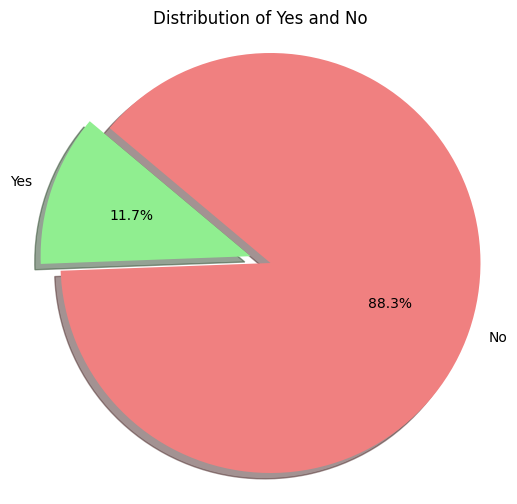

In [7]:
# Count the number of occurrences of 'yes' and 'no' in the variable 'y'
count_yes = data['y'].value_counts()['yes']  # Count occurrences of 'yes'
count_no = data['y'].value_counts()['no']    # Count occurrences of 'no'

# Print the number of occurrences of 'yes' and 'no'
print("Number of 'yes' occurrences:", count_yes)
print("Number of 'no' occurrences:", count_no)

# Define labels, sizes, colors, and explode for the pie chart
labels = ['Yes', 'No']                              # Labels for pie chart
sizes = [count_yes, count_no]                       # Sizes of the pie chart slices
colors = ['lightgreen', 'lightcoral']               # Colors for the pie chart slices
explode = (0.1, 0)                                  # Explode the 'Yes' slice to highlight it

# Create the pie chart
plt.figure(figsize=(6, 6))                          # Set figure size
plt.pie(sizes, explode=explode, labels=labels,      # Plot pie chart with labels, sizes, colors, and explode
        colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Yes and No')             # Set title of the pie chart
plt.axis('equal')                                   # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()                                          # Display the pie chart

We notice that there is an asymmetry in the number of 'yes' and 'no' in the dataset, almost 1 to 8. There may be some problems with the ability to predict correctly and we will eventually take action to tackle this problem. We will intially see the results without performing any sort of undersampling and oversampling to have an idea of the first results when performing 'standard' classification. We can anticipate that the accuracy, even with a seemingly good value, may not be a satisfactory indicator, but we will provide more details later when we obtain the results.

Now we look at the categorical variables to later set them as dummy variables. Furthermore, we take out the 'y' variable to treat it on its own.

In [8]:
# Display the data types of each column in the dataset
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

We start by checking interactions between variables.

First, we print some boxplots to understand what kind of effects there are between 'y' and the numeric variables.

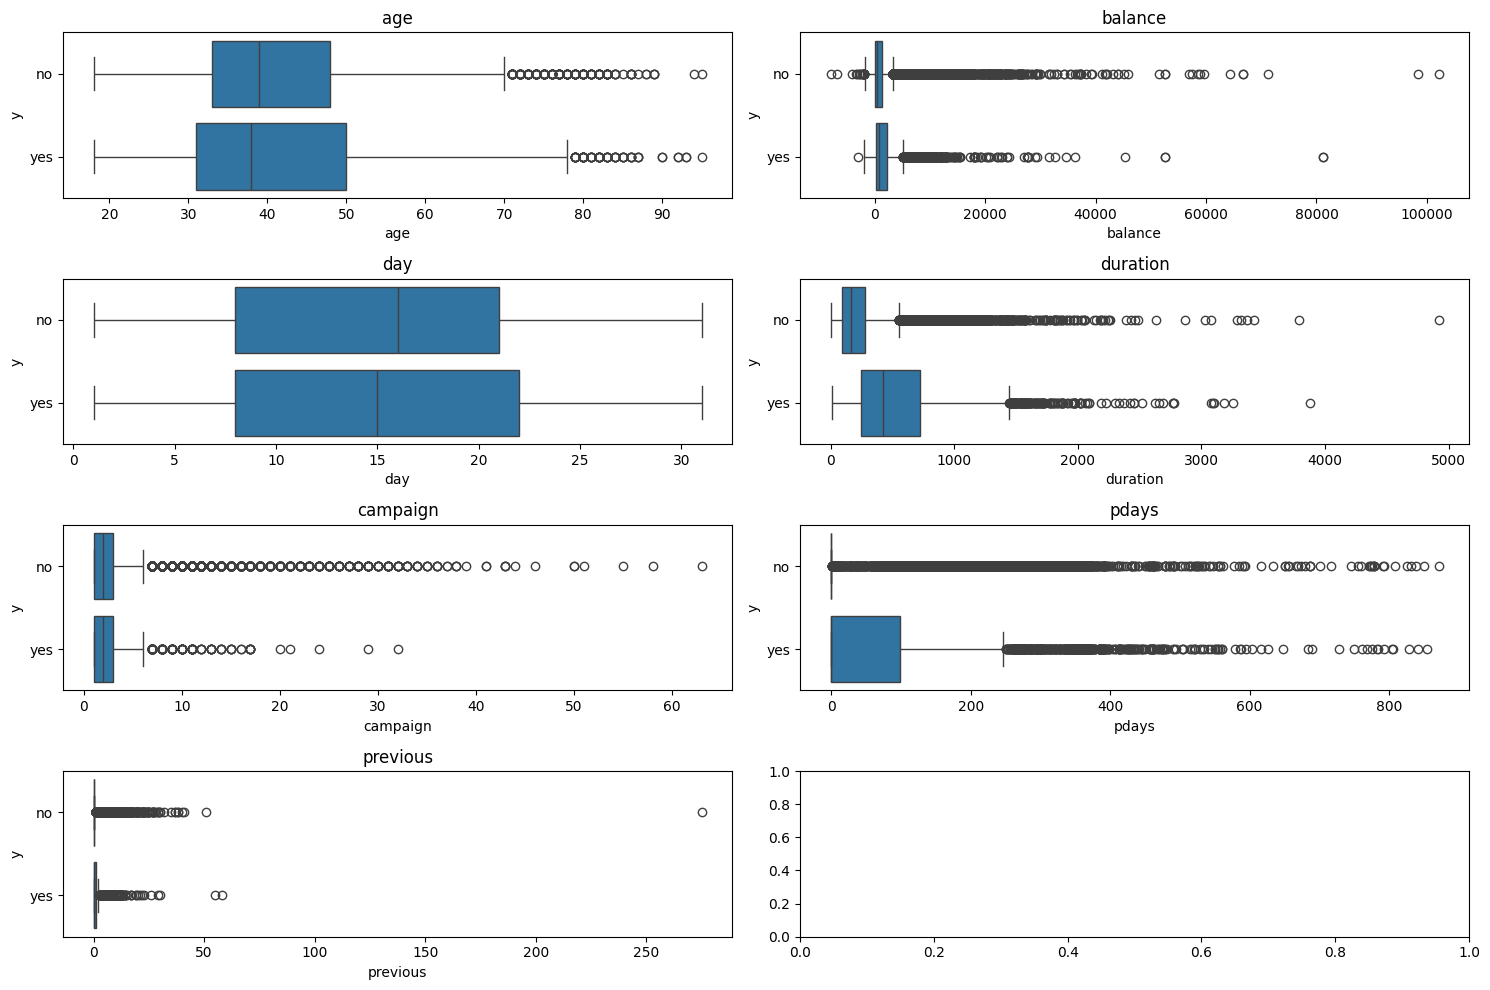

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))

# Select columns with data types that are 'int64' (usually numeric) from the dataset
int64 = data.select_dtypes(include=['int64']).columns

for i, o in enumerate(int64):
    # Calculate the position of the subplot in the grid
    row = i // 2  # Integer division to determine the row index
    col = i % 2   # Modulo operation to determine the column index
    
    # Create a boxplot for the current feature
    sns.boxplot(x=data[o], y=data['y'], ax=axes[row, col])
    axes[row, col].set_title(o)  # Set subplot title to feature name

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

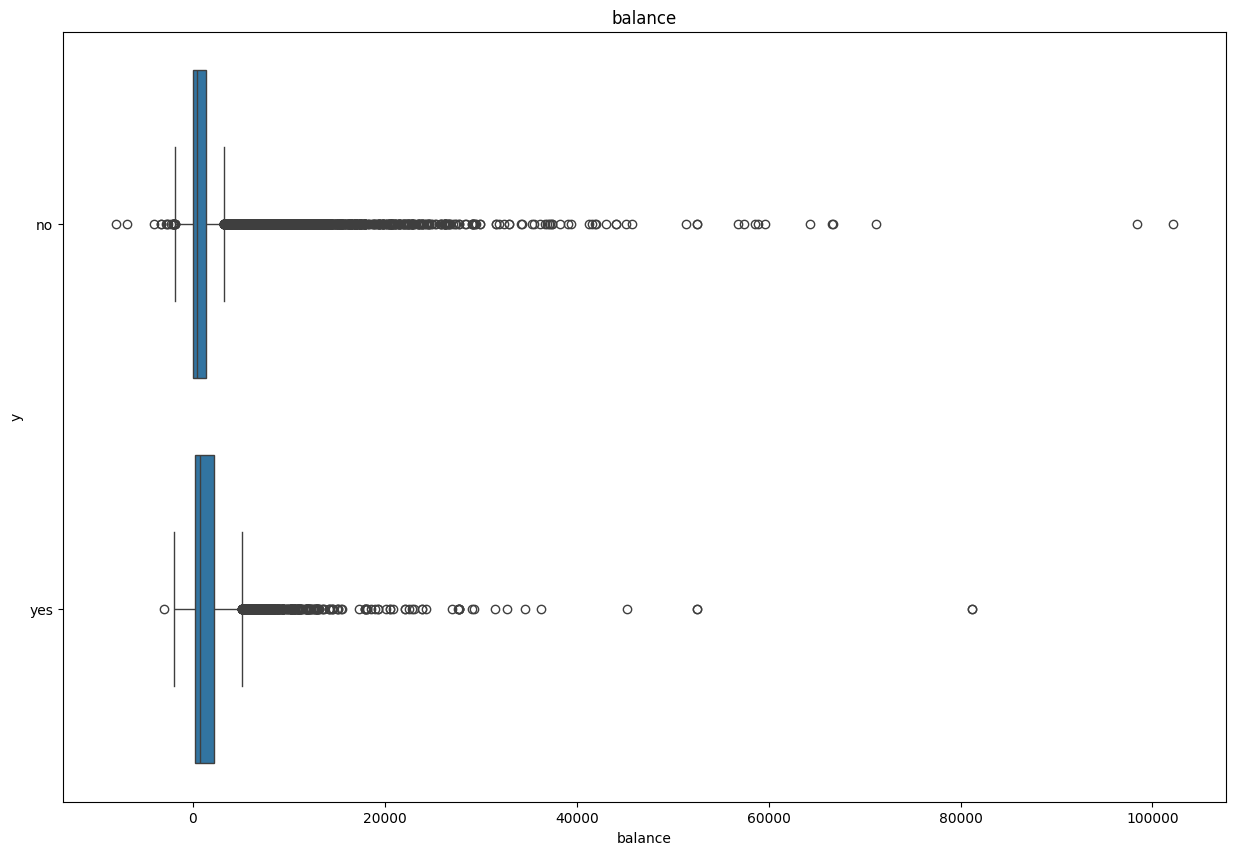

In [10]:
#we print again y~balance to have a clearer view of the boxplot, considering the scale of balance
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.boxplot(x=data['balance'], y=data['y'])
axes.set_title('balance')
plt.show()

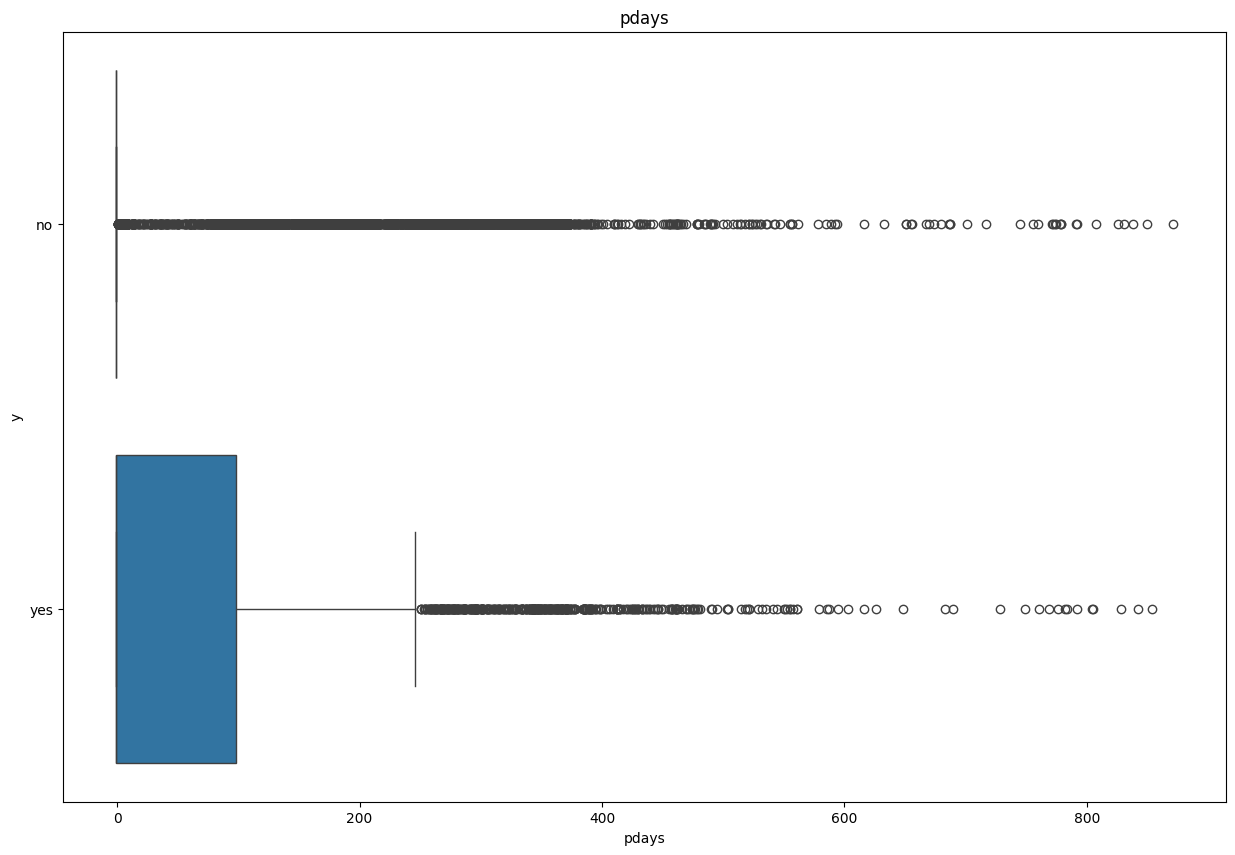

In [11]:
#we print again y~pdays to have a clearer view of the boxplot, considering the scale of pdays
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.boxplot(x=data['pdays'], y=data['y'])
axes.set_title('pdays')
plt.show()

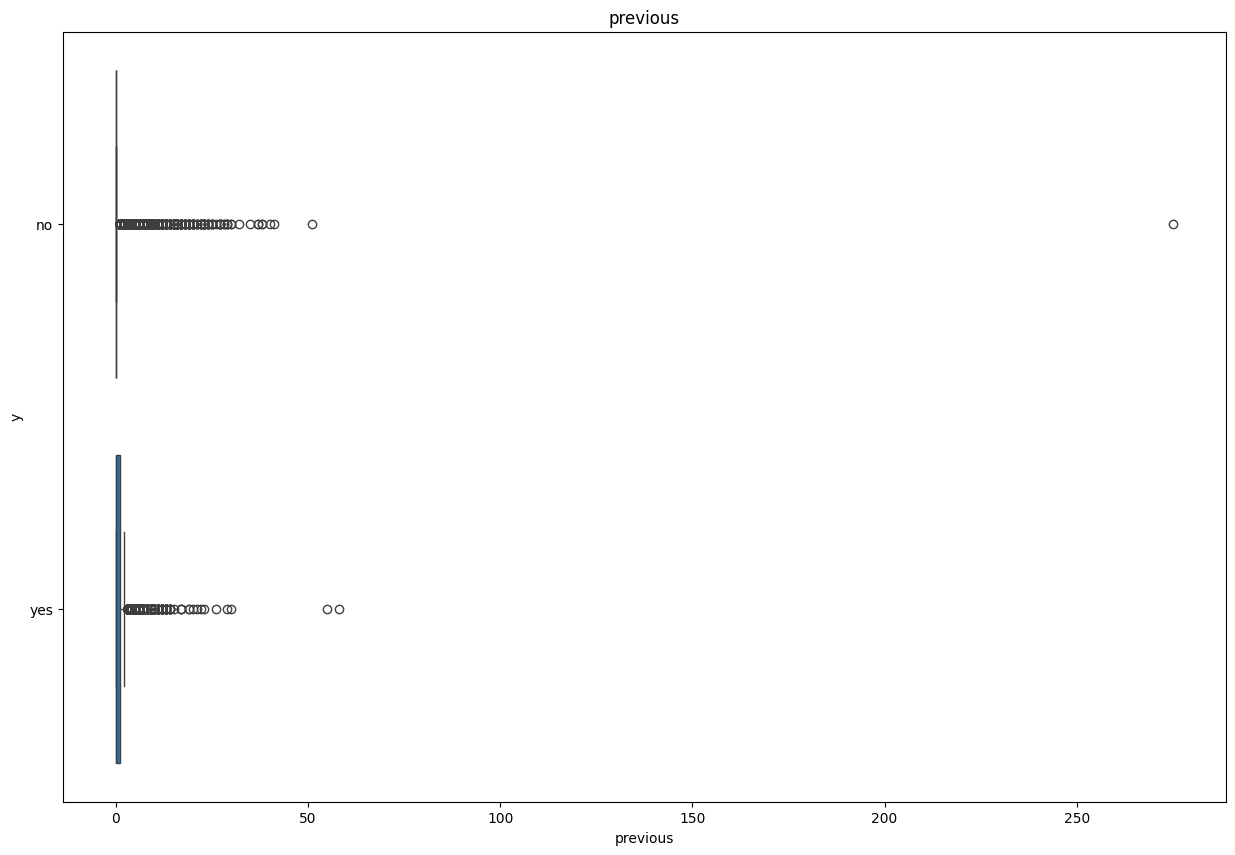

In [12]:
#we print again y~previous to have a clearer view of the boxplot, considering the scale of previous
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.boxplot(x=data['previous'], y=data['y'])
axes.set_title('previous')
plt.show()

Here we describe briefly the effect of the numeric variables on 'y':
- age: we can't really notice a huge difference between 'yes' and 'no' given the age;
- balance: we can't identify from the plot any particular effect of balance on 'y', but here we emphasise the attention on the considerable amount of outliers;
- day: we can't really notice any difference between 'yes' and 'no' conditioning on the day;
- duration: we can notice a huge difference in the two boxplots, most likely it is a variable that has a considerable effect on 'y';
- campaign: it does not present any substantial difference, but we can notice that the outliers for 'no' are more frequent, especially the ones with high count of phone calls received;
- pday: we can notice a huge difference in the two boxplots, most likely it is a variable that has a considerable effect on 'y';
- previous: here the distribution for both responses is concentrated for very low values of previous, but it admits very big outliers.

Overall, apart from 'pdays' and 'duration', the other variables don't seem to have any particular effects on 'y'. We can underline the presence of a huge number of outliers for most variables.

Then, we print some barplots to understand what kind of effects there are between 'y' and the categorical variables. We also use percentage crosstabs considering that the different amount of 'yes' and 'no' could make the evaluation part more difficult.

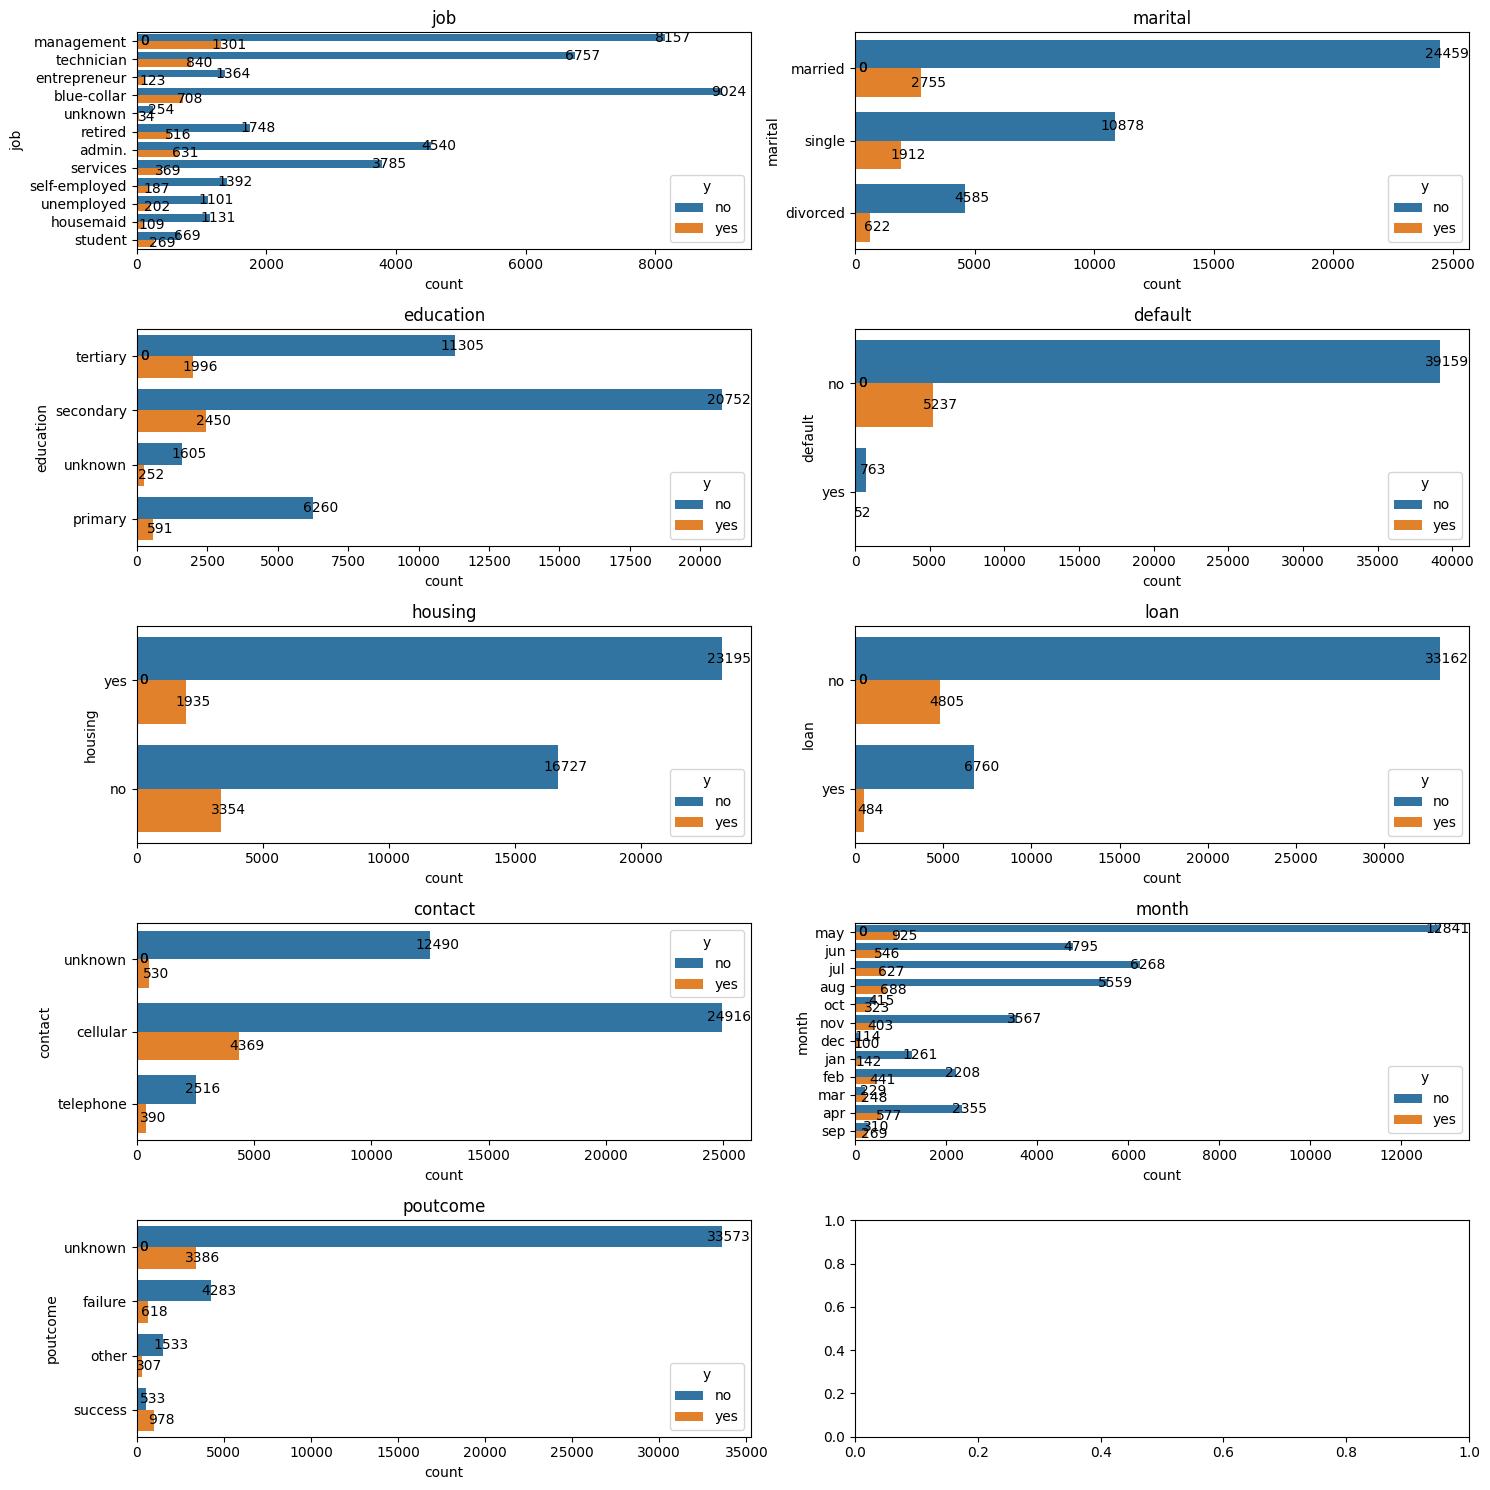

In [13]:
# Select columns with data types that are 'object' (usually strings) from the dataset
obj = data.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for i, o in enumerate(obj[0:len(obj)-1]): # we exclude the last variable y
    # Calculate the position of the subplot in the grid
    row = i // 2  # Integer division to determine the row index
    col = i % 2   # Modulo operation to determine the column index
    
    # Create a countplot for the current feature with horizontal orientation
    sns.countplot(y=data[o], hue=data['y'], ax=axes[row, col], orient='h')
    axes[row, col].set_title(o)  # Set subplot title to feature name
    for p in axes[row, col].patches:
        axes[row, col].annotate(f'{p.get_width():.0f}', (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                                ha='center', va='center', fontsize=10, color='black', xytext=(5, 0),
                                textcoords='offset points')


plt.tight_layout()
plt.show()

We show also the percentage tables to have a reasonable scale to compare each category of every variable.

In [14]:
# Iterate through each categorical variable in the dataset except the last one ('y')
for i, o in enumerate(obj[0:len(obj)-1]):
    # Compute the cross-tabulation of the 'y' variable with the current categorical variable
    crosstab_result = pd.crosstab(data['y'], data[o])
    
    # Compute percentages and round to two decimal places
    crosstab_percentage = crosstab_result.apply(lambda x: round(x / x.sum() * 100, 2), axis=1)
    
    # Print the crosstabulation with percentages
    print(crosstab_percentage)

job  admin.  blue-collar  entrepreneur  housemaid  management  retired  \
y                                                                        
no    11.37        22.60          3.42       2.83       20.43     4.38   
yes   11.93        13.39          2.33       2.06       24.60     9.76   

job  self-employed  services  student  technician  unemployed  unknown  
y                                                                       
no            3.49      9.48     1.68       16.93        2.76     0.64  
yes           3.54      6.98     5.09       15.88        3.82     0.64  
marital  divorced  married  single
y                                 
no          11.48    61.27   27.25
yes         11.76    52.09   36.15
education  primary  secondary  tertiary  unknown
y                                               
no           15.68      51.98     28.32     4.02
yes          11.17      46.32     37.74     4.76
default     no   yes
y                   
no       98.09  1.91
yes      99.

loan     no    yes
y                 
no    83.07  16.93
yes   90.85   9.15
contact  cellular  telephone  unknown
y                                    
no          62.41       6.30    31.29
yes         82.61       7.37    10.02
month    apr    aug   dec   feb   jan    jul    jun   mar    may   nov   oct  \
y                                                                              
no      5.90  13.92  0.29  5.53  3.16  15.70  12.01  0.57  32.17  8.93  1.04   
yes    10.91  13.01  1.89  8.34  2.68  11.85  10.32  4.69  17.49  7.62  6.11   

month   sep  
y            
no     0.78  
yes    5.09  
poutcome  failure  other  success  unknown
y                                         
no          10.73   3.84     1.34    84.10
yes         11.68   5.80    18.49    64.02


Here we describe briefly the effect of the categorical variables on 'y':
- job: it presents some slight differences in the categories 'blue-collar', 'management', 'retired', 'services' and 'student'. Overall we are talking about low differences;
- marital: there is variation only in 'married' and 'single';
- education: there is a small difference for all the categories except for 'unknown';
- default: the distributions for 'yes' and 'no' are almost the same;
- housing:  here we can identify a significant variation for the variable 'y' given 'housing';
- loan: slight difference for the two categories of 'loan';
- contact: the significant change is for the categories 'cellular' and 'unknown';
- month: for almost all the months we can notice slight changes;
- poutcome: the significant change is for the categories 'success' and 'unknown'.

Overall, we can state that there are some variables with clearer differences and some with very slight changes.

## Data process

Here we prepare the data to be used in the next session for the first models without resampling.

In [15]:
# Select columns with data types that are 'object' (usually strings) from the dataset
# The include parameter specifies the data types to include, in this case, 'object' data types
# The columns method retrieves the column labels of the selected columns
types = data.select_dtypes(include=['object']).columns

In [16]:
# Iterate over each column label in the 'types' variable
# 'types' contains the column labels of columns with data types classified as 'object' (usually strings)
for obj in types:
    # Use LabelEncoder to transform the values in the selected column to numeric labels
    # Fit the LabelEncoder to the column's unique values and transform the column values
    data[obj] = LabelEncoder().fit_transform(data[obj])

# Display the data types of each column in the dataset after encoding
data.dtypes

age          int64
job          int32
marital      int32
education    int32
default      int32
balance      int64
housing      int32
loan         int32
contact      int32
day          int64
month        int32
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int32
y            int32
dtype: object

We have a look at the new dataset with new labels with .head() and .describe() and finally we rescale the data in order to have the same scale (we used MinMaxScaler(), so the scale is between 0 and 1). The 'y' variable will follow the following rule:

- 'no': 0
- 'yes': 1

In [17]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [18]:
data.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,4.339762,1.167725,1.224813,0.018027,1362.272058,0.555838,0.160226,0.640242,15.806419,5.523014,258.163080,2.763841,40.197828,0.580323,2.559974,0.116985
std,10.618762,3.272657,0.608230,0.747997,0.133049,3044.765829,0.496878,0.366820,0.897951,8.322476,3.006911,257.527812,3.098021,100.128746,2.303441,0.989059,0.321406
min,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,1.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,-1.000000,0.000000,3.000000,0.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,3.000000,0.000000
75%,48.000000,7.000000,2.000000,2.000000,0.000000,1428.000000,1.000000,0.000000,2.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000,3.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,11.000000,4918.000000,63.000000,871.000000,275.000000,3.000000,1.000000


We rescale the data

In [19]:
# Create an instance of the MinMaxScaler class
scaler = MinMaxScaler()

# Apply MinMaxScaler to scale the values of all columns in the dataset
# Fit the scaler to the data and transform the data using the fitted scaler
data[:] = scaler.fit_transform(data[:])

# Display summary statistics (mean, standard deviation, min, max, etc.) of the dataset
# This provides information about the distribution and scale of the data after scaling
data.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.297873,0.394524,0.583862,0.408271,0.018027,0.085171,0.555838,0.160226,0.320121,0.493547,0.502092,0.052494,0.028449,0.047245,0.002110,0.853325,0.116985
std,0.137906,0.297514,0.304115,0.249332,0.133049,0.027643,0.496878,0.366820,0.448975,0.277416,0.273356,0.052364,0.049968,0.114827,0.008376,0.329686,0.321406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194805,0.090909,0.500000,0.333333,0.000000,0.073457,0.000000,0.000000,0.000000,0.233333,0.272727,0.020943,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.272727,0.363636,0.500000,0.333333,0.000000,0.076871,1.000000,0.000000,0.000000,0.500000,0.545455,0.036600,0.016129,0.000000,0.000000,1.000000,0.000000
75%,0.389610,0.636364,1.000000,0.666667,0.000000,0.085768,1.000000,0.000000,1.000000,0.666667,0.727273,0.064864,0.032258,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Correlation

In this final subsection of data processing, we check if there is some correlation between the variables in the dataset and later comment.

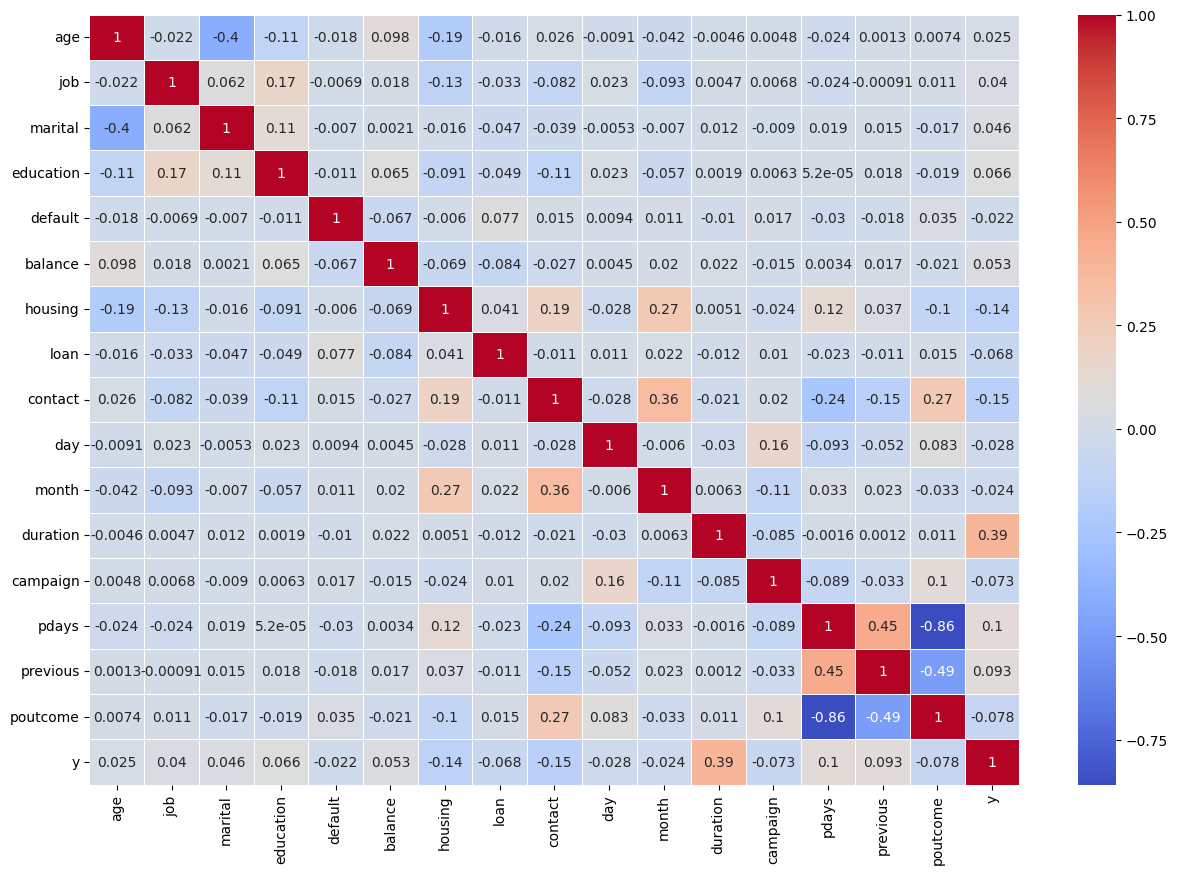

In [20]:
# Create a figure with a specific size (width = 15 inches, height = 10 inches)
plt.figure(figsize=(15, 10))

# Generate a heatmap to visualize the Pearson correlation matrix of the dataset
# The heatmap shows pairwise correlations between numerical columns
sns.heatmap(data.corr(method='pearson'), annot=True, linewidths=.5, cmap="coolwarm")

# Display the heatmap
plt.show()

Without surprise, we can notice, given also the previous results, that there is a generally null correlation between all variables apart from some exceptions like:
- pdays and previous (0.45)
- poutcome and pdays (-0.86)
- poutcome and previous (-0.49)

Overall this helps with our classification problem. Low correlation between predictors make us evade eventual problems like redundancy of features or overfitting.

# Analysis with not resampled data

Now we create the Y vector and X matrix to work properly. Afterwards, we divide the dataset in train and test data. We decide to go for 85% for train data and the remaing one for test data.

In [21]:
# Import dataset with pandas, we take again the original dataset
file_path = "C:/Users/Marco Plazzogna/Desktop/MAGISTRALE/PRIMO ANNO/SECONDO SEMESTRE/MACHINE LEARNING/Project/Bank_Marketing.csv"
data = pd.read_csv(file_path, delimiter=';',)

Now we encode all variables from object to int32.

In [22]:
# Iterate over each column label in the 'types' variable (defined before)
# 'types' contains the column labels of columns with data types classified as 'object' (usually strings)
for obj in types:
    # Use LabelEncoder to transform the values in the selected column to numeric labels
    # Fit the LabelEncoder to the column's unique values and transform the column values
    data[obj] = LabelEncoder().fit_transform(data[obj])

# Display the data types of each column in the dataset after encoding
data.dtypes

age          int64
job          int32
marital      int32
education    int32
default      int32
balance      int64
housing      int32
loan         int32
contact      int32
day          int64
month        int32
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int32
y            int32
dtype: object

Here we pick a fraction to divide the data in training and testig data. We choose arbitrarily 0.85.

In [23]:
# Specify the fraction of data to be used for training
fraction_train = 0.85

# Calculate the fraction of data to be used for testing
fraction_test = 1.0 - fraction_train

# Split the dataset into training and testing sets
data_train, data_test = train_test_split(data, train_size=fraction_train, test_size=fraction_test, random_state=0)

In [24]:
# Print the shape of the training dataset
print(data_train.shape)

# Print the shape of the testing dataset
print(data_test.shape)

(38429, 17)
(6782, 17)


Here we split between X and Y.

In [25]:
# Separating the target variable 'y' from the rest of the dataset for both the training and testing sets
# Training set
X_train = data_train[data_train.columns[:-1]]  # Features (all columns except the last one)
Y_train = data_train['y']  # Target variable 'y'

# Testing set
X_test = data_test[data_test.columns[:-1]]  # Features (all columns except the last one)
Y_test = data_test['y']  # Target variable 'y'

Knowing the dataset have different scales, we rescale using StandardScaler() (having mean 0 and variance 1).

In [26]:
# Create an instance of the StandardScaler class
scaler = StandardScaler()

# Apply standardization to scale the features of the training set
# Fit the scaler to the training data and transform the training data using the fitted scaler
X_train[:] = scaler.fit_transform(X_train[:])

# Apply standardization to scale the features of the testing set
# Fit the scaler to the testing data and transform the testing data using the fitted scaler
X_test[:] = scaler.fit_transform(X_test[:])

# Display summary statistics (mean, standard deviation, min, max, etc.) of the scaled training data
X_train.describe()

C:\Users\Marco Plazzogna\AppData\Local\Temp\ipykernel_33644\474013649.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[:] = scaler.fit_transform(X_train[:])
C:\Users\Marco Plazzogna\AppData\Local\Temp\ipykernel_33644\474013649.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[:] = scaler.fit_transform(X_test[:])


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04,3.842900e+04
mean,1.915538e-16,8.875082e-17,1.728792e-17,-3.587012e-17,2.514606e-17,1.405221e-17,3.069299e-17,-1.109385e-17,2.477627e-17,-8.338879e-17,-6.952147e-17,7.580799e-17,-1.617853e-17,-1.386732e-17,1.645588e-17,-5.694844e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-2.161009e+00,-1.329989e+00,-1.919355e+00,-1.640140e+00,-1.365077e-01,-3.054939e+00,-1.116066e+00,-4.360707e-01,-7.110138e-01,-1.777590e+00,-1.834594e+00,-9.984225e-01,-5.647830e-01,-4.120099e-01,-2.451839e-01,-2.579572e+00
25%,-7.476191e-01,-1.024211e+00,-2.754829e-01,-3.015480e-01,-1.365077e-01,-4.226605e-01,-1.116066e+00,-4.360707e-01,-7.110138e-01,-9.371894e-01,-8.377950e-01,-6.008434e-01,-5.647830e-01,-4.120099e-01,-2.451839e-01,4.458315e-01
50%,-1.822632e-01,-1.068778e-01,-2.754829e-01,-3.015480e-01,-1.365077e-01,-3.000095e-01,8.960046e-01,-4.360707e-01,-7.110138e-01,2.326853e-02,1.590044e-01,-3.036241e-01,-2.428123e-01,-4.120099e-01,-2.451839e-01,4.458315e-01
75%,6.657706e-01,8.104555e-01,1.368389e+00,1.037044e+00,-1.365077e-01,1.979391e-02,8.960046e-01,-4.360707e-01,1.520482e+00,6.235547e-01,8.235374e-01,2.329146e-01,7.915844e-02,-4.120099e-01,-2.451839e-01,4.458315e-01
max,5.094392e+00,2.033567e+00,1.368389e+00,2.375635e+00,7.325592e+00,3.277931e+01,8.960046e-01,2.293206e+00,1.520482e+00,1.824127e+00,1.820337e+00,1.798501e+01,1.939740e+01,8.296780e+00,1.150582e+02,4.458315e-01


In [27]:
X_test.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03,6.782000e+03
mean,-1.045070e-16,9.953046e-17,1.592487e-16,9.219664e-17,-2.095378e-17,-4.085987e-17,-1.063404e-16,-1.047689e-17,-4.871754e-17,6.914748e-17,-1.063404e-16,-4.400294e-17,-5.552752e-17,-3.562143e-17,-2.462069e-17,6.390903e-17
std,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00
min,-2.060399e+00,-1.304274e+00,-1.922966e+00,-1.622550e+00,-1.295824e-01,-2.838692e+00,-1.133596e+00,-4.409475e-01,-7.243875e-01,-1.787780e+00,-1.849372e+00,-1.019186e+00,-5.958663e-01,-4.083001e-01,-3.134239e-01,-2.639334e+00
25%,-7.460647e-01,-9.998519e-01,-2.773438e-01,-2.949913e-01,-1.295824e-01,-4.303555e-01,-1.133596e+00,-4.409475e-01,-7.243875e-01,-9.426497e-01,-8.464312e-01,-6.169041e-01,-5.958663e-01,-4.083001e-01,-3.134239e-01,4.396115e-01
50%,-1.827786e-01,-8.658650e-02,-2.773438e-01,-2.949913e-01,-1.295824e-01,-3.011014e-01,8.821483e-01,-4.409475e-01,-7.243875e-01,2.321376e-02,1.565092e-01,-3.051360e-01,-2.682485e-01,-4.083001e-01,-3.134239e-01,4.396115e-01
75%,7.560314e-01,8.266789e-01,1.368278e+00,1.032567e+00,-1.295824e-01,2.925346e-02,8.821483e-01,-4.409475e-01,1.480143e+00,6.268785e-01,8.251361e-01,2.600694e-01,5.936925e-02,-4.083001e-01,-3.134239e-01,4.396115e-01
max,4.886795e+00,2.044366e+00,1.368278e+00,2.360126e+00,7.717096e+00,2.273380e+01,8.821483e-01,2.267844e+00,1.480143e+00,1.834208e+00,1.828077e+00,1.205898e+01,1.250885e+01,7.901650e+00,2.057601e+01,4.396115e-01


## Logistic Classification

Now we can start implementing the logistic regression. We make some attempts with different norms, inverse regularisation strength (C) and solvers.

In [28]:
# List of regularization norms to be used in logistic regression
norms = ['l1', 'l2']

# List of regularisation strength values
reg_strength = [1.0, 0.1, 0.5, 0.05, 0.01]

# List of solver algorithms for logistic regression 
solvers = ['liblinear', 'newton-cholesky', 'sag', 'saga']

# Empty list to store the results
tab = []

# Headers for the resulting DataFrame
headers = ['Norm used', 'l1_ratio', 'Reg. parameter' , 'Solver used', 'score']

# Loop over each combination of regularization norm, regularization strength, and solver
for n in norms:
    for reg in reg_strength:
        for s in solvers:
            # Check if the combination is valid
            if (s == 'newton-cholesky' or s == 'sag') and n != 'l2':  
                pass  # Skip this iteration if the combination is invalid
            else:
                # Create and train a logistic regression model with the current combination of parameters
                clf = LogisticRegression(C=reg, penalty=n, solver=s, max_iter=1000) 
                clf.fit(X_train, Y_train)  # Fit data
                score = clf.score(X_train, Y_train)  # Compute accuracy of the prediction
                # Append the results to the tab list
                if n == 'l1':
                    tab.append([n, 0, reg, s, score])  # Append l1_ratio as 0 for l1 penalty
                else:
                    tab.append([n, 1, reg, s, score])  # Append l1_ratio as 1 for l2 penalty

# List of l1_ratio values for elasticnet penalty
l1rat=[0.25, 0.5, 0.75]

# Iterate over each combination of regularization strength and l1_ratio
for reg in reg_strength:
    for l in l1rat:
        # Create and train a logistic regression model with elasticnet penalty
        clf = LogisticRegression(C=reg, penalty='elasticnet', solver='saga', max_iter=1000, l1_ratio=l) 
        clf.fit(X_train, Y_train)  # Fit data
        score = clf.score(X_train, Y_train)  # Compute accuracy of the prediction
        # Append the results to the tab list
        tab.append(['elasticnet', l, reg, s, score])

# Create a DataFrame from the tab list with specified headers
tab = pd.DataFrame(tab, columns=headers)
tab

,Norm used,l1_ratio,Reg. parameter,Solver used,score
0,l1,0.00,1.00,liblinear,0.891280
1,l1,0.00,1.00,saga,0.891280
2,l1,0.00,0.10,liblinear,0.891228
3,l1,0.00,0.10,saga,0.891202
4,l1,0.00,0.50,liblinear,0.891228
5,l1,0.00,0.50,saga,0.891254
6,l1,0.00,0.05,liblinear,0.890968
7,l1,0.00,0.05,saga,0.890994
8,l1,0.00,0.01,liblinear,0.890864
9,l1,0.00,0.01,saga,0.890916


Here, with some loops, we found several results implementing different norms, inverse regularisation strength (C) and solvers. We want to look for the ones that produced a higher score, even though they all have similar value of 0.89. We'll take the first five to have a look first.

In [29]:
# We take the first 5 results with higher accuracy score
tab.nlargest(5, 'score')

,Norm used,l1_ratio,Reg. parameter,Solver used,score
12,l2,1.00,1.0,sag,0.891332
13,l2,1.00,1.0,saga,0.891332
21,l2,1.00,0.5,saga,0.891332
30,elasticnet,0.25,1.0,saga,0.891332
36,elasticnet,0.25,0.5,saga,0.891332


Overall, we can't see many differences on the value of the score between the methods implemented. We notice though, that the best fits are with the norm l2, regularisation parameter 1.0 and the solver 'sag'. So the final model that we decide to use is the following:

In [30]:
# Model chosen
clf = LogisticRegression(C=1.0, penalty='l2', solver='sag', max_iter=1000) 
clf.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, solver='sag')

Finally we compute the predictions and we look at the confusion matrix, the validation accuracy and the misclassified 'yes' as 'no'. Later we print the ROC curve and the corrisponding AUC value.

In [31]:
# Generate predictions using the trained classifier on the test dataset
y_pred = clf.predict(X_test)

# Compute and print accuracy metrics based on the predictions
LR_acc, LR_mis = conf_acc(pred=y_pred, test=Y_test)

Confusion matrix
 [[5863  133]
 [ 607  179]] 

Validation accuracy: 89.08876437629017 %
Fraction of yes misclassified as no: 77.2264631043257 %


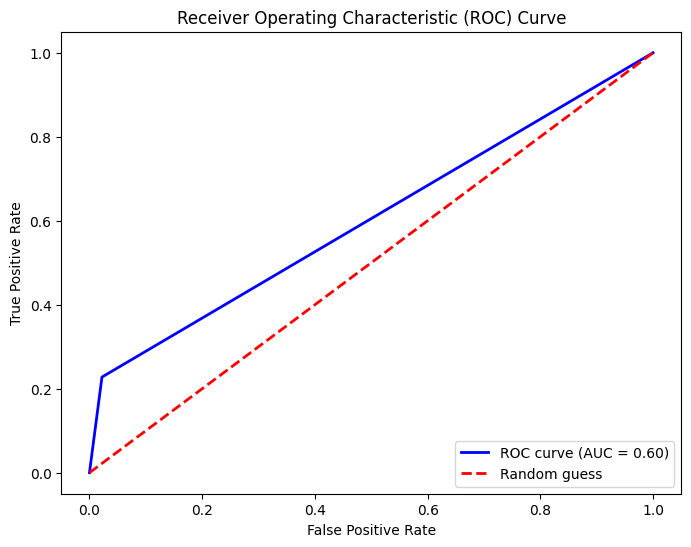

In [32]:
# Compute ROC curve and AUC and store the AUC value
LR_roc = roc_func(pred=y_pred, test=Y_test)

Looking at the results, especially the confusion matrix, we can say that we can improve the problem even more. 0.89 of score is already a good value for the accuracy, but we can make some slight improvements considering the low value of AUC and the high value for the fraction of misclassified 'yes'.

So now we try to implement a KNN to see if we can obtain better results.

# K-Nearest Neighbors

In this context, there is no need to perform the folding method: the dataset is large enough (45211 observations divided in 38429 for training and 6782 for testing).

We first do cross validation on the parameter K.

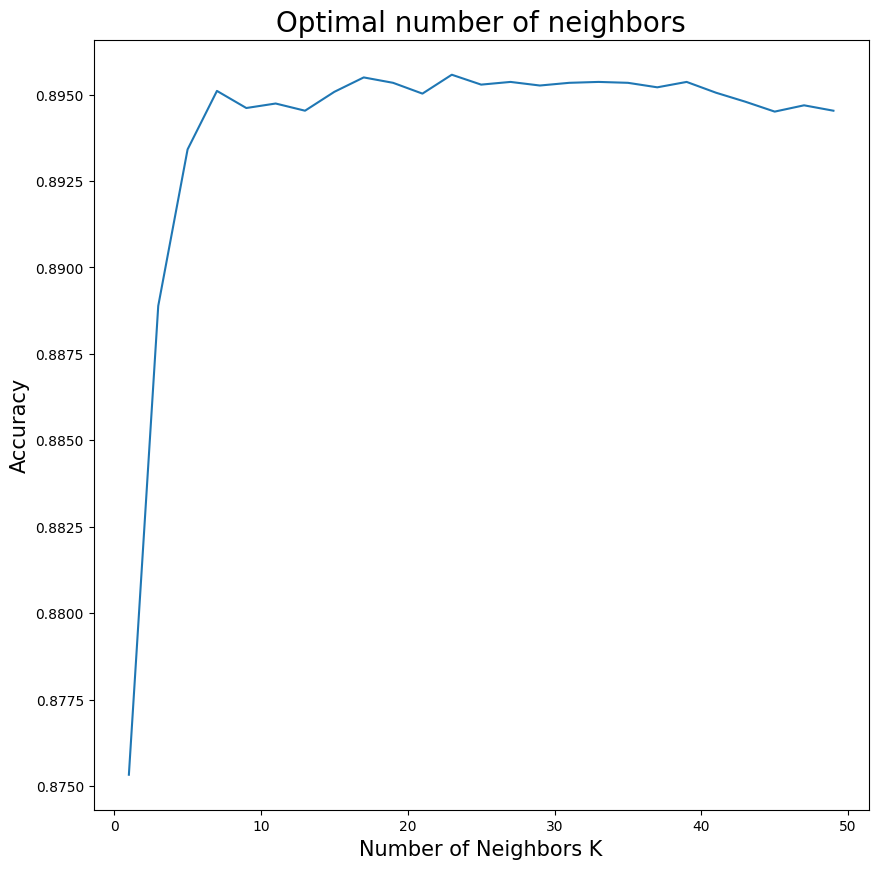

In [33]:
# Define a list of K values for KNN
k_list = list(range(1, 50, 2))

# Initialize an empty list to store cross-validation scores
cv_scores = []

# Iterate over each value of K
for k in k_list:
    # Create a KNN classifier with the current value of K
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation and calculate the mean accuracy score
    scores = cross_val_score(knn, X_train, Y_train, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the cross-validation scores against the number of neighbors
plt.figure(figsize=(10, 10))
plt.title('Optimal number of neighbors', fontsize=20)
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.plot(k_list, cv_scores)
plt.show()

We check for the optimal value of K considering the maximum score obtained with the cross-validation implemented before.

In [34]:
# Find the index of the maximum cross-validation score
max_score_index = cv_scores.index(max(cv_scores))

# Retrieve the optimal number of neighbors corresponding to the maximum score
optimal_k = k_list[max_score_index]

# Print the optimal number of neighbors and the corresponding maximum score
print("Optimal number of neighbors:", optimal_k)
print("Maximum Score:", max(cv_scores))

Optimal number of neighbors: 23
Maximum Score: 0.8955736502891382


Here we repeat the same procedure but by looking at the validation accuracy.

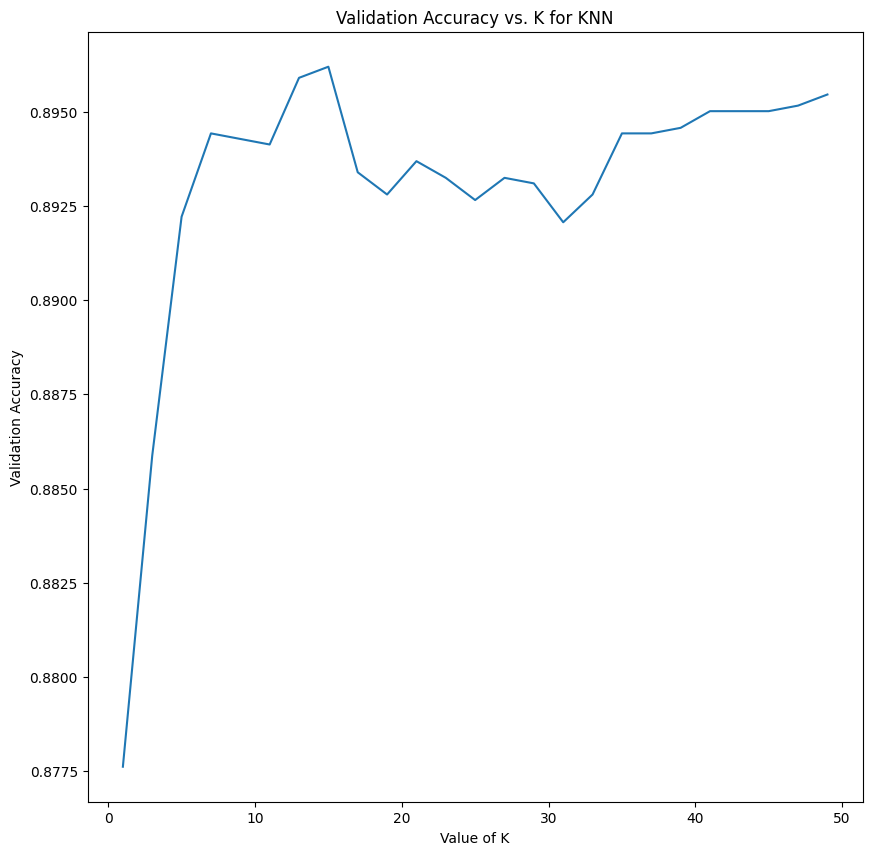

In [35]:
# Import the necessary library
from sklearn.metrics import accuracy_score

# Create a list of values for K (number of neighbors)
k_list = list(range(1, 50, 2))

# Initialize an empty list to store the accuracies for each value of K
accuracies = []

# Iterate over each value of K
for k in k_list:
    # Create a KNN classifier with the current value of K
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    # Fit the classifier on the training data
    knn.fit(X_train, Y_train)
    
    # Use the trained classifier to predict the labels for the test data
    y_pred = knn.predict(X_test)
    
    # Compute the accuracy score by comparing the predicted labels with the true labels
    acc = accuracy_score(Y_test, y_pred)
    
    # Append the accuracy score to the list of accuracies
    accuracies.append(acc)

# Plot the values of K against the corresponding validation accuracies
plt.figure(figsize=(10, 10))
plt.plot(k_list, accuracies)
plt.xlabel('Value of K')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. K for KNN')
plt.show()

We look at optimal value of K.

In [36]:
# Find the value of K corresponding to the maximum validation accuracy
optimal_k = k_list[accuracies.index(max(accuracies))]

# Print the optimal number of neighbors and the corresponding validation accuracy
print("Optimal number of neighbors:", optimal_k)
print("Validation accuracy:", max(accuracies))

Optimal number of neighbors: 15
Validation accuracy: 0.8961958124447066


Now we try to compare the to results between KNN with 23 and 15 neighbors.

Finally we compute the predictions and we look at the confusion matrix, the validation accuracy and the misclassified 'yes' as 'no'. Later we print the ROC curve and the corrisponding AUC value.

In [37]:
# Create a KNN classifier with 23 neighbors, fit the training data, and make predictions on the test data
knn = neighbors.KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

In [38]:
# Compute and print accuracy metrics based on the predictions
KNN_acc, KNN_mis = conf_acc(pred=y_pred, test=Y_test)

Confusion matrix
 [[5863  133]
 [ 591  195]] 

Validation accuracy: 89.3246829843704 %
Fraction of yes misclassified as no: 75.19083969465649 %


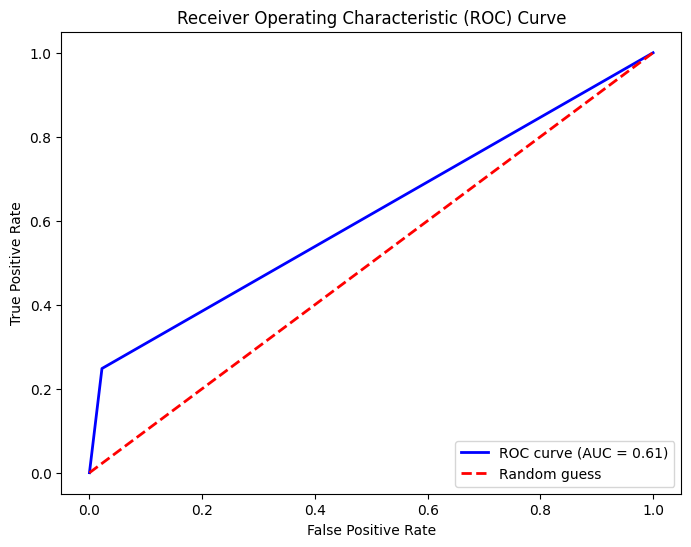

In [39]:
# Compute ROC curve and AUC and store the AUC value
KNN_roc = roc_func(pred=y_pred, test=Y_test)

In [40]:
# Create a KNN classifier with 15 neighbors, fit the training data, and make predictions on the test data
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

In [41]:
# Compute and print accuracy metrics based on the predictions
KNN_acc, KNN_mis = conf_acc(pred=y_pred, test=Y_test)

Confusion matrix
 [[5855  141]
 [ 563  223]] 

Validation accuracy: 89.61958124447065 %
Fraction of yes misclassified as no: 71.62849872773536 %


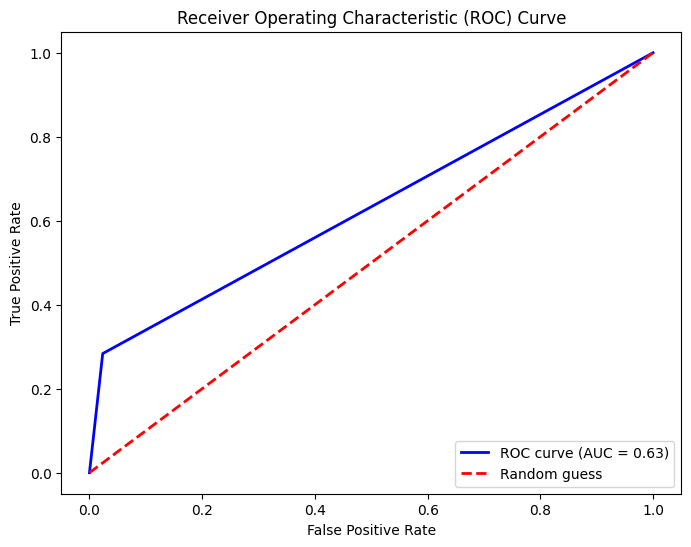

In [42]:
# Compute ROC curve and AUC and store the AUC value
KNN_roc = roc_func(pred=y_pred, test=Y_test)

We slightly prefer 15 neighbors as the accuracy is moderately higher and the AUC value as well.

Overall the result is better than the best one obtained with the logistic regression, so we tend to prefer KNN until this moment, but we still have some criticalities for misclassificaion of 'yes' already mentioned in the previous subsection about Logistic Regression.

Now we might want to check if there are other techniques to achieve an even better result. Now we could try the Support Vector Machines method to see if we can further improve this already satisfying level of accuracy (89% is a good level for accuracy) and hopefully increase the AUC value.

# SVM

In this section we try to reach better results with an implementation of Support Vector Machines, a method which tries to separate the dataset linearly. 

In [43]:
# Initialize an SVM classifier and define a list of C values for regularization
binary_classifier = svm.SVC()
C_values = np.logspace(-2, 3, 6)

# Initialize empty lists to store train and test accuracies
train_accuracy = []
test_accuracy = []

# Iterate over each C value
for C in C_values:
    # Construct the SVM classifier with the current value of C and fit it to the training data
    binary_classifier = svm.SVC(C=C)
    binary_classifier.fit(X_train,Y_train)
    
    # Predict the labels for the test data
    y_pred = binary_classifier.predict(X_test)
    
    # Compute the accuracy score for the test data
    test_score = accuracy_score(y_true=Y_test, y_pred=y_pred)
    
    # Append the test accuracy to the list
    test_accuracy.append(test_score)
    
    # Print the test accuracy for the current C value
    print('C =',C,': test accuracy =',test_score)

C = 0.01 : test accuracy = 0.8841049837805957
C = 0.1 : test accuracy = 0.8947213211442052
C = 1.0 : test accuracy = 0.8973754054851076
C = 10.0 : test accuracy = 0.8981126511353583
C = 100.0 : test accuracy = 0.8869065172515482
C = 1000.0 : test accuracy = 0.875552934237688


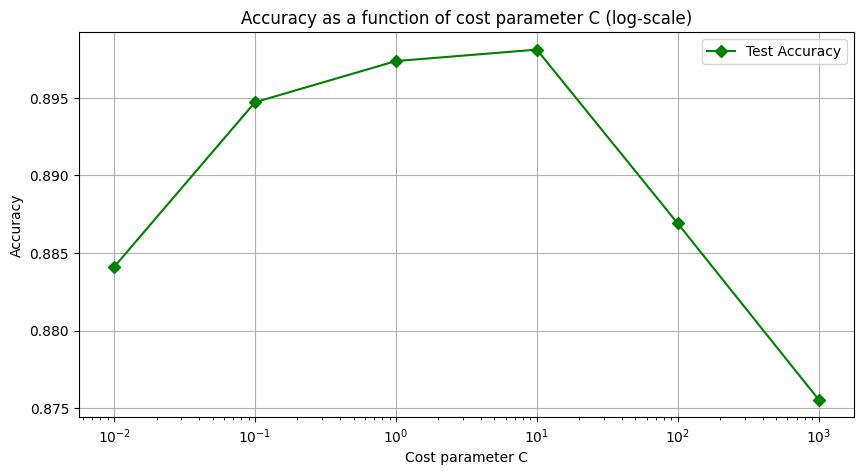

In [44]:
# Create a plot with a log scale on the x-axis
plt.figure(figsize=(10, 5))
plt.semilogx(C_values, test_accuracy, '-gD', label="Test Accuracy")  # Plot test accuracy against C values
plt.grid(True)  # Add grid lines
plt.xlabel("Cost parameter C")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.legend()  # Show legend
plt.title('Accuracy as a function of cost parameter C (log-scale)')  # Title of the plot
plt.show()  # Show the plot

The parameter C=10.0 seems to give the higher accuracy.

Finally we compute the predictions and we look at the confusion matrix, the validation accuracy and the misclassified 'yes' as 'no'. Later we print the ROC curve and the corrisponding AUC value.

In [45]:
# Create a Support Vector Machine classifier with a specified cost parameter (C)
binary_classifier = svm.SVC(C=10.0)

# Fit the classifier to the training data
binary_classifier.fit(X_train, Y_train)

# Use the trained classifier to predict the labels of the test data
y_pred = binary_classifier.predict(X_test)

In [46]:
# Compute and print accuracy metrics based on the predictions
SVM_acc, SVM_mis = conf_acc(pred=y_pred, test=Y_test)

Confusion matrix
 [[5820  176]
 [ 515  271]] 

Validation accuracy: 89.81126511353582 %
Fraction of yes misclassified as no: 65.52162849872774 %


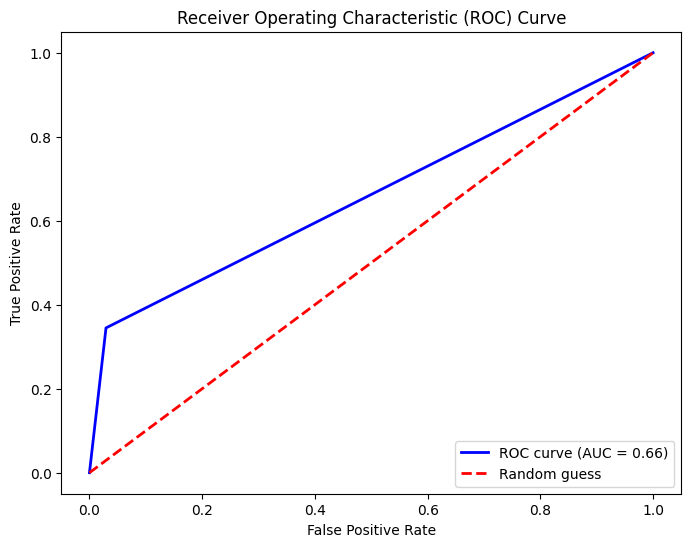

In [47]:
# Compute ROC curve and AUC and store the AUC value
SVM_roc = roc_func(pred=y_pred, test=Y_test)

Again, given the dataset, we find a troublesome result for the misclassified 'yes', even though the AUC value and the accuracy continue to grow. Now we might consider to make an adjustment and implement some undersampling or oversampling procedure with the libraries SMOTE and RandomSampling

# Rescaling data

We rescale the data first.

In [48]:
# Create an instance of the MinMaxScaler class
scaler = MinMaxScaler()

# Apply MinMaxScaler to scale the values of all columns in the dataset
# Fit the scaler to the data and transform the data using the fitted scaler
data[:] = scaler.fit_transform(data[:])

Here we apply the methods from imblearn. We first apply undersampling and then oversampling and we choose arbitrarily a sampling ratio of 0.5. We might also want to look at different values for this parameter.

In [49]:
# Define the oversampling strategy with a sampling ratio of 1
overdata = SMOTE(sampling_strategy=1)

# Define the undersampling strategy with a sampling ratio of 0.5
underdata = RandomUnderSampler(sampling_strategy=0.5)

# Separate the target variable ('y') from the feature variables ('X')
Y = data['y']
X = data.drop(columns=['y'])

# Apply undersampling to the entire dataset
X_under, Y_under = underdata.fit_resample(X, Y)

# Apply oversampling to the entire dataset
X_resampled, Y_resampled = overdata.fit_resample(X_under, Y_under)

We count the new resampled data points and we plot the new distribution with a pieplot.

Number of 'yes' occurrences: 10578
Number of 'no' occurrences: 10578


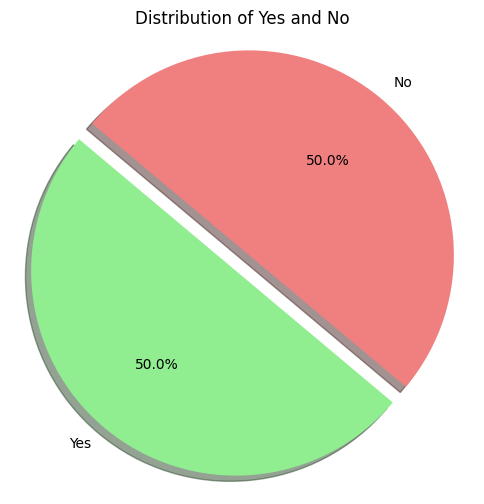

In [50]:
# Count the number of occurrences of 'yes' and 'no' in the resampled target variable 'Y_resampled'
count_yes = Y_resampled.value_counts()[1]
count_no = Y_resampled.value_counts()[0]

# Print the counts of 'yes' and 'no'
print("Number of 'yes' occurrences:", count_yes)
print("Number of 'no' occurrences:", count_no)

# Prepare data for pie chart
labels = ['Yes', 'No']
sizes = [count_yes, count_no]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # Explode the 'Yes' slice to highlight it

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Yes and No')
plt.axis('equal') 
plt.show()

Now the distributions of 'yes' and 'no' has an equal ratio. We proceed by testing whether the accuracy the fraction of misclassified 'yes' behave overall better.

We split again the data with a test size of 15%.

In [51]:
# Split the resampled data into training and testing sets with a test size of 15%
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.15)

# Logistic Regression with resampled data

We start again by implementing the Logistic Regression trying with various norms, regularisation parameters and solvers.

In [52]:
# List of regularization norms to be used in logistic regression
norms = ['l1', 'l2']

# List of regularisation strength values
reg_strength = [1.0, 0.1, 0.5, 0.05, 0.01]

# List of solver algorithms for logistic regression 
solvers = ['liblinear', 'newton-cholesky', 'sag', 'saga']

# Empty list to store the results
tab = []

# Headers for the resulting DataFrame
headers = ['Norm used', 'l1_ratio', 'Reg. parameter' , 'Solver used', 'score']

# Loop over each combination of regularization norm, regularization strength, and solver
for n in norms:
    for reg in reg_strength:
        for s in solvers:
            # Check if the combination is valid
            if (s == 'newton-cholesky' or s == 'sag') and n != 'l2':  
                pass  # Skip this iteration if the combination is invalid
            else:
                # Create and train a logistic regression model with the current combination of parameters
                clf = LogisticRegression(C=reg, penalty=n, solver=s, max_iter=1000) 
                clf.fit(X_train, Y_train)  # Fit data
                score = clf.score(X_train, Y_train)  # Compute accuracy of the prediction
                # Append the results to the tab list
                if n == 'l1':
                    tab.append([n, 0, reg, s, score])  # Append l1_ratio as 0 for l1 penalty
                else:
                    tab.append([n, 1, reg, s, score])  # Append l1_ratio as 1 for l2 penalty

# List of l1_ratio values for elasticnet penalty
l1rat=[0.25, 0.5, 0.75]

# Iterate over each combination of regularization strength and l1_ratio
for reg in reg_strength:
    for l in l1rat:
        # Create and train a logistic regression model with elasticnet penalty
        clf = LogisticRegression(C=reg, penalty='elasticnet', solver='saga', max_iter=1000, l1_ratio=l) 
        clf.fit(X_train, Y_train)  # Fit data
        score = clf.score(X_train, Y_train)  # Compute accuracy of the prediction
        # Append the results to the tab list
        tab.append(['elasticnet', l, reg, s, score])

# Create a DataFrame from the tab list with specified headers
tab = pd.DataFrame(tab, columns=headers)
tab

,Norm used,l1_ratio,Reg. parameter,Solver used,score
0,l1,0.00,1.00,liblinear,0.818096
1,l1,0.00,1.00,saga,0.818096
2,l1,0.00,0.10,liblinear,0.813814
3,l1,0.00,0.10,saga,0.814592
4,l1,0.00,0.50,liblinear,0.816483
5,l1,0.00,0.50,saga,0.816539
6,l1,0.00,0.05,liblinear,0.810477
7,l1,0.00,0.05,saga,0.811534
8,l1,0.00,0.01,liblinear,0.789957
9,l1,0.00,0.01,saga,0.790457


We have a look at the first five with higher accuracy.

In [53]:
# We take the first 5 results with higher accuracy score
tab.nlargest(5, 'score')

,Norm used,l1_ratio,Reg. parameter,Solver used,score
0,l1,0.00,1.0,liblinear,0.818096
1,l1,0.00,1.0,saga,0.818096
32,elasticnet,0.75,1.0,saga,0.817150
5,l1,0.00,0.5,saga,0.816539
4,l1,0.00,0.5,liblinear,0.816483


They all have a good accuracy of around 82%, worse than the ones obtained before the resampling, but we might want to check the confusion matrix. The model chosen is the one with norm l1, regularisation parameter 1.0 and with the solver 'liblinear'.

In [54]:
# Model chosen
clf = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', max_iter=1000) 
clf.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

Finally we compute the predictions and we look at the confusion matrix, the validation accuracy and the misclassified 'yes' as 'no'. Later we print the ROC curve and the corrisponding AUC value.

In [55]:
# Perform prediction on the test set
y_pred = clf.predict(X_test)

In [56]:
# Compute and print accuracy metrics based on the predictions
R_LR_acc, R_LR_mis = conf_acc(pred=y_pred, test=Y_test)

Confusion matrix
 [[1301  317]
 [ 300 1256]] 

Validation accuracy: 80.56080655324511 %
Fraction of yes misclassified as no: 19.28020565552699 %


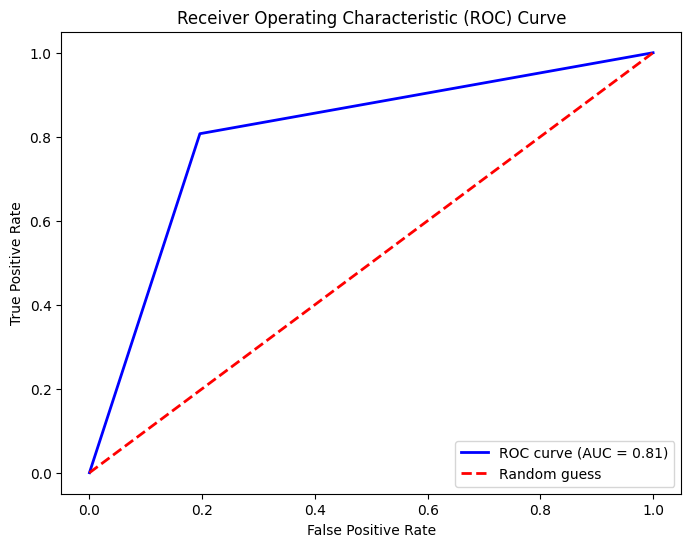

In [57]:
# Compute ROC curve and AUC and store the AUC value
R_LR_roc = roc_func(pred=y_pred, test=Y_test)

The value of the AUC has seen a great improvement, as well as the fraction for misclassified 'yes' that is much lower than before.

Now we test the new data with the K nearest neighbors method.

# KNN with resampled data

We first do cross-validation on the parameter K.

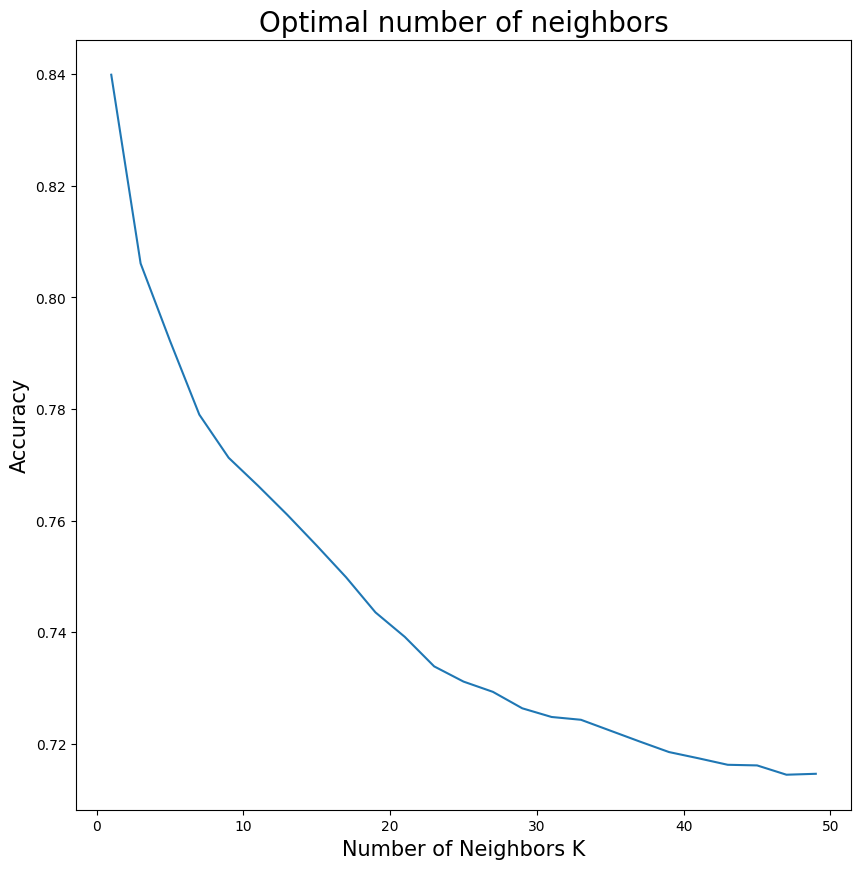

In [58]:
# Create a list of odd values for the number of neighbors (K) ranging from 1 to 49
k_list = list(range(1, 50, 2))

# Initialize an empty list to store cross-validated scores
cv_scores = []

# Iterate over each value of K
for k in k_list:
    # Create a KNN classifier with the current value of K
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation and compute the mean accuracy score
    scores = cross_val_score(knn, X_train, Y_train, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the accuracy against the number of neighbors
plt.figure(figsize=(10, 10))
plt.title('Optimal number of neighbors', fontsize=20)
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.plot(k_list, cv_scores)
plt.show()

We check for the optimal value of K considering the maximum score obtained with the cross-validation implemented before.

In [59]:
# Find the index of the maximum cross-validated score in the list of scores
max_score_index = cv_scores.index(max(cv_scores))

# Retrieve the corresponding value of K (number of neighbors) using the index
optimal_k = k_list[max_score_index]

# Print the optimal number of neighbors and the corresponding maximum score
print("Optimal number of neighbors:", optimal_k)
print("Maximum Score:", max(cv_scores))

Optimal number of neighbors: 1
Maximum Score: 0.8398958562366428


Here we repeat the same procedure but by looking at the validation accuracy.

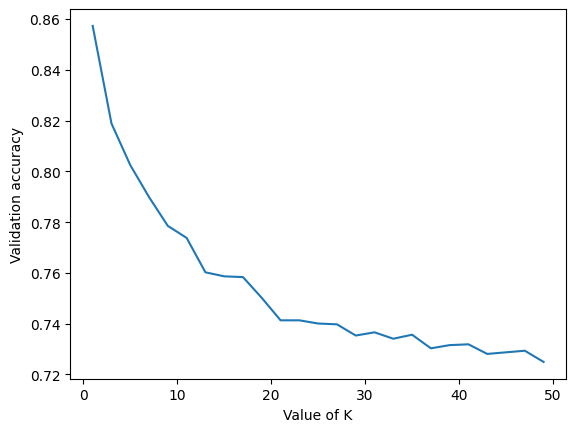

In [60]:
# Create a list of values for the number of neighbors (K) to be tested
k_list = list(range(1, 50, 2))

# Initialize an empty list to store the accuracies for each value of K
accuracies = []

# Loop over each value of K
for k in k_list:
    # Initialize a KNN classifier with the current value of K
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    # Fit the classifier on the training data
    knn.fit(X_train, Y_train)
    
    # Use the trained classifier to predict the labels of the test data
    y_pred = knn.predict(X_test)
    
    # Compute the accuracy score of the predictions
    acc = accuracy_score(Y_test, y_pred)
    
    # Append the accuracy score to the list of accuracies
    accuracies.append(acc)

# Plot the accuracies against the values of K
plt.figure()
plt.plot(k_list, accuracies)
plt.xlabel('Value of K')
plt.ylabel('Validation accuracy')
plt.show()

We look at optimal value of K.

In [61]:
# Find the value of K that corresponds to the maximum accuracy
optimal_k = k_list[accuracies.index(max(accuracies))]

# Print the optimal number of neighbors and the corresponding validation accuracy
print("Optimal number of neighbors:", optimal_k)
print("Validation accuracy:", max(accuracies))

Optimal number of neighbors: 1
Validation accuracy: 0.8572778827977315


Finally we compute the predictions and we look at the confusion matrix, the validation accuracy and the misclassified 'yes' as 'no'. Later we print the ROC curve and the corrisponding AUC value.

In [62]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

In [63]:
# Compute and print accuracy metrics based on the predictions
R_KNN_acc, R_KNN_mis = conf_acc(pred=y_pred, test=Y_test)

Confusion matrix
 [[1336  282]
 [ 171 1385]] 

Validation accuracy: 85.72778827977315 %
Fraction of yes misclassified as no: 10.989717223650386 %


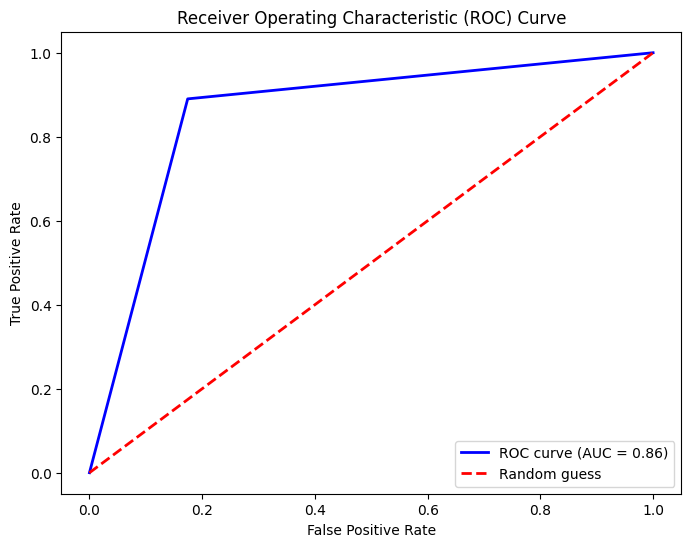

In [64]:
# Compute ROC curve and AUC and store the AUC value
R_KNN_roc = roc_func(pred=y_pred, test=Y_test)

Again, even if the validation accuracy is a little bit worse than before, an AUC value of almost 0.86 is very satisfying for the new data and, in fact, the level of misclassified 'yes' is consistently decreased to 0.11.

Finally we have a look at the Support Vector Machines method with resampled data.

# SVM  with resampled data

We start by looking at the best value for the parameter C.

In [65]:
# Initialize lists to store train and test accuracies for different values of C
train_accuracy = []
test_accuracy = []

# Iterate over different values of C
for C in C_values:
    # Create an SVM classifier with the specified value of C
    binary_classifier = svm.SVC(C=C)
    
    # Fit the classifier on the training data
    binary_classifier.fit(X_train, Y_train)
    
    # Predict the labels for the test data
    y_pred = binary_classifier.predict(X_test)
    
    # Compute the accuracy of the predictions on the test data
    test_score = accuracy_score(y_true=Y_test, y_pred=y_pred)
    
    # Append the test accuracy to the list of test accuracies
    test_accuracy.append(test_score)
    
    # Print the value of C and the corresponding test accuracy
    print('C =', C, ': test accuracy =', test_score)

C = 0.01 : test accuracy = 0.6584751102709515
C = 0.1 : test accuracy = 0.7889098928796471
C = 1.0 : test accuracy = 0.8248267170762444
C = 10.0 : test accuracy = 0.8358538122243226
C = 100.0 : test accuracy = 0.8446754883427852
C = 1000.0 : test accuracy = 0.8544423440453687


We plot the accuracy with different value of C.

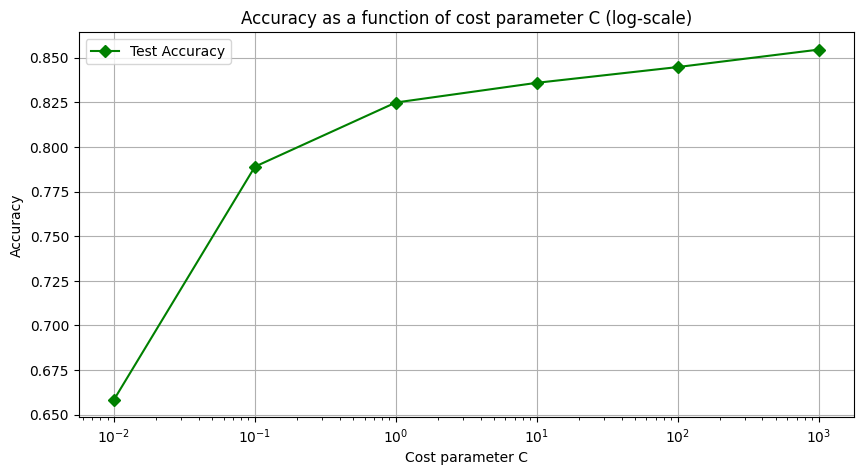

In [66]:
# Create a plot to visualize the relationship between cost parameter C and test accuracy
plt.figure(figsize=(10, 5))

# Plot the test accuracy against the values of C using a semilogx plot
plt.semilogx(C_values, test_accuracy, '-gD', label="Test Accuracy")

# Add grid lines to the plot
plt.grid(True)

# Set the labels for x-axis and y-axis
plt.xlabel("Cost parameter C")
plt.ylabel("Accuracy")

# Add a legend to the plot
plt.legend()

# Set the title of the plot
plt.title('Accuracy as a function of cost parameter C (log-scale)')

# Display the plot
plt.show()

It seems that C=1000.0 is the best choice with an accuracy of 0.8563.

In [67]:
# Initialize an SVM classifier with a specified value of cost parameter C
binary_classifier = svm.SVC(C=1000.0)

# Fit the classifier to the training data
binary_classifier.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = binary_classifier.predict(X_test)

Finally we compute the predictions and we look at the confusion matrix, the validation accuracy and the misclassified 'yes' as 'no'. Later we print the ROC curve and the corrisponding AUC value.

In [68]:
# Compute and print accuracy metrics based on the predictions
R_SVM_acc, R_SVM_mis = conf_acc(pred=y_pred, test=Y_test)

Confusion matrix
 [[1331  287]
 [ 175 1381]] 

Validation accuracy: 85.44423440453687 %
Fraction of yes misclassified as no: 11.246786632390746 %


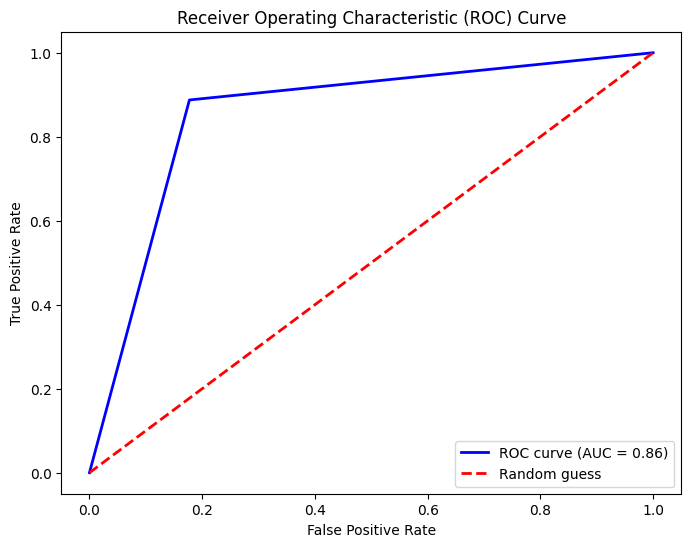

In [69]:
# Compute ROC curve and AUC and store the AUC value
R_SVM_roc = roc_func(pred=y_pred, test=Y_test)

Like all the other methods implemented with resampled data, the accuracy is slightly lower but the AUC has increased its value to 0.85 and the fraction for 'yes' misclassificated is much lower than SVM before resampling.

# Neural Network

After noticing the effectiveness of the resampling procedure, we would like to pick a final and different approach, by using a Neural Network on the resampled data to see if we can obtain even better results, maybe trying to replicate the same level of accuracy as before, so around 0.90.

First of all, we need to convert the train and the test datasets to tensors.

In [70]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)  
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)  

# Create datasets and dataloaders
full_train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [71]:
# Set the length of the training subset
reduced_length = 15000

# Calculate the number of samples to be used for validation by subtracting the 
# reduced training set length from the total length of the full training dataset
validation_length = len(full_train_dataset) - reduced_length

# Define the indices for the training subset, starting from index 0 up to the reduced_length
indices_train = range(reduced_length)

# Define the indices for the validation set. This starts immediately after the last
# training index and continues up to the sum of reduced_length and validation_length
indices_validation = range(reduced_length, reduced_length + validation_length)

# Create a training dataset as a subset of the full training dataset using the indices defined for training.
# This will include data from the beginning of the full dataset up to the defined reduced_length.
train_dataset = torch.utils.data.Subset(full_train_dataset, indices=indices_train)

# Similarly, create a validation dataset as a subset of the full training dataset using the indices defined for validation.
# This subset starts from the end of the training subset and includes the remaining data up to the total length of the full dataset.
validation_dataset = torch.utils.data.Subset(full_train_dataset, indices=indices_validation)

Now, we create the class to later compute the Neural Network by performing cross-validation on many parameters, namely on learning rates, batch sizes, hidden sizes and optimisers. The optimisers are chosen mostly arbitraly between many offered by torch.optim, so we picked Adam and SGD since known and then we added a variant of Adam, AdamW that refers to the "Weight Decay" component that is added to Adam and finaly Adagrad (Adaptive Gradient Algorithm) that adapts the learning rate for each parameter based on the history of gradients for that parameter. Considering the amout of time taken by all the neural networks running, we opt for a very simple structure.

In [72]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        # Define the input size, hidden size, and number of classes
        self.input_size = input_size
        # Define the ReLU activation function
        self.relu = nn.ReLU()
        # Define the first linear layer with input size and hidden size
        self.layer_1 = nn.Linear(input_size, hidden_size)
        # Define the second linear layer with hidden size and number of classes
        self.layer_2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Forward pass through the network
        # Apply the first linear layer to the input
        out = self.layer_1(x)
        # Apply the ReLU activation function
        out = self.relu(out)
        # Apply the second linear layer to the output of the first layer
        out = self.layer_2(out)
        # No activation and no softmax at the end since the loss function requires only unnormalized logits
        return out

In [73]:
# Parameters
# Determine input size from the training dataset
input_size = train_dataset[0][0].shape[0]
# Concatenate all labels from the training dataset to find the number of unique classes
all_labels = torch.cat([train_dataset[i][1].unsqueeze(0) for i in range(len(train_dataset))], dim=0)
num_classes = len(torch.unique(all_labels))
# Number of epochs for training
num_epochs = 20
early_stopping_steps = 10 

# Parameters for grid search
# Define different hyperparameters to search over
hidden_sizes = [50, 100]  # Different sizes of hidden layers
batch_sizes = [32, 64, 128]  # Different batch sizes for training
learning_rates = [0.1, 0.001, 0.0001]  # Different learning rates
# Dictionary containing various optimizers and their corresponding torch optimizer functions
optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD,
    'Adagrad': torch.optim.Adagrad,
    'AdamW': torch.optim.AdamW
}

# Placeholder for the best model's performance and parameters
best_accuracy = 0
best_model_params = {}

# Grid search over hyperparameters
for hidden_size in hidden_sizes:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for opt_name, opt_func in optimizers.items():
                # Print current hyperparameters being used
                print(f"Training with {opt_name}, Hidden: {hidden_size}, Batch: {batch_size}, LR: {learning_rate}")
                
                # Model and optimizer initialization
                model = NeuralNet(input_size, hidden_size, num_classes)
                optimizer = opt_func(model.parameters(), lr=learning_rate)
                loss_function = nn.CrossEntropyLoss()
                
                # Create data loaders for training and testing
                train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(dataset=validation_dataset, batch_size=validation_length, shuffle=True)
                test_loader = DataLoader(dataset=test_dataset,batch_size=len(test_dataset),shuffle=True)
                
                min_validation_loss = float('inf') 
                steps_without_improvement = 0

                # Training loop
                for epoch in range(num_epochs):
                    model.train()
                    for inputs, labels in train_loader:
                        outputs = model(inputs)
                        loss = loss_function(outputs, labels)
                        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                
                    steps_without_improvement += 1
                    # Check if the validation loss improved
                    if steps_without_improvement >= early_stopping_steps:
                        print("Early stopping triggered")
                        break
                    # Evaluate the model
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        val_loss = loss_function(outputs, labels)
                    if val_loss < min_validation_loss:
                        min_validation_loss = val_loss
                        steps_without_improvement = 0
                        # Save the best model
                        print(f'-- Better model // saving')
                        torch.save(model, 'best_model.pth')
                    
                    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

                del model
                model = torch.load('best_model.pth')
                with torch.no_grad():
                    n_correct = 0
                    n_samples = 0
                    for inputs, labels in test_loader:
                        outputs = model(inputs)
                        loss = loss_function(outputs, labels)
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        n_correct += (predicted == labels).sum().item()
                        n_samples += labels.size(0)
                accuracy = 100.0 * n_correct / n_samples            
                # Update best model if the current one is better
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model_params = {
                        'hidden_size': hidden_size,
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'optimizer': opt_name
                    }
                    torch.save(model, 'best_final_model.pth')
                print(f'{opt_name} Accuracy: {accuracy} %')


# Print the best model parameters and validation accuracy
print(f"Best Model Parameters: {best_model_params}, Best Validation Accuracy: {best_accuracy}%")

Training with Adam, Hidden: 50, Batch: 32, LR: 0.1
-- Better model // saving
Epoch 1, Validation Loss: 0.4189
-- Better model // saving
Epoch 2, Validation Loss: 0.4166
-- Better model // saving
Epoch 3, Validation Loss: 0.4118
Epoch 4, Validation Loss: 0.4160
Epoch 5, Validation Loss: 0.4118
Epoch 6, Validation Loss: 0.4148
Epoch 7, Validation Loss: 0.4202
Epoch 8, Validation Loss: 0.4308
-- Better model // saving
Epoch 9, Validation Loss: 0.4088
Epoch 10, Validation Loss: 0.4554
-- Better model // saving
Epoch 11, Validation Loss: 0.4087
Epoch 12, Validation Loss: 0.4122
Epoch 13, Validation Loss: 0.4224
Epoch 14, Validation Loss: 0.4310
Epoch 15, Validation Loss: 0.4152
Epoch 16, Validation Loss: 0.4090
-- Better model // saving
Epoch 17, Validation Loss: 0.4065
Epoch 18, Validation Loss: 0.4150
Epoch 19, Validation Loss: 0.4367
Epoch 20, Validation Loss: 0.4217
Adam Accuracy: 81.2224322621298 %
Training with SGD, Hidden: 50, Batch: 32, LR: 0.1
-- Better model // saving
Epoch 1, Val

The procedure has found that the best model with the highest accuracy (0.8352) is the Neural Network implementing 'Adagrad', with hidden size of 100, a batch size of 32 and learning rate of 0.1. Overall, by looking at other implementations, some of the them were similar in terms of the accuracy score, by achieving more than 0.80, while others performed very poorly, even worse than random guessing.

In [74]:
# Correctly initializing the model with the parameters that match the saved model
best_model = torch.load('best_final_model.pth')

# Prepare the DataLoader for the test dataset
test_loader = DataLoader(dataset=test_dataset, batch_size=best_model_params['batch_size'], shuffle=False)

# Make predictions with the best model
best_model.eval()  # Set the model to evaluation mode
y_true = []  # Placeholder for true labels
y_pred = []  # Placeholder for predicted labels
with torch.no_grad():
    # Iterate through the test dataset
    for inputs, labels in test_loader:
        # Forward pass through the model
        outputs = best_model(inputs)
        # Predict the class with the highest probability
        _, predicted = torch.max(outputs, 1)
        # Append true labels and predicted labels to lists
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

Finally we compute the predictions and we look at the confusion matrix, the validation accuracy and the misclassified 'yes' as 'no'. Later we print the ROC curve and the corrisponding AUC value.

In [75]:
# Compute and print accuracy metrics based on the predictions
NN_acc, NN_mis = conf_acc(np.array(y_true), np.array(y_pred))

Confusion matrix
 [[1322  296]
 [ 227 1329]] 

Validation accuracy: 83.52236925015754 %
Fraction of yes misclassified as no: 14.588688946015424 %


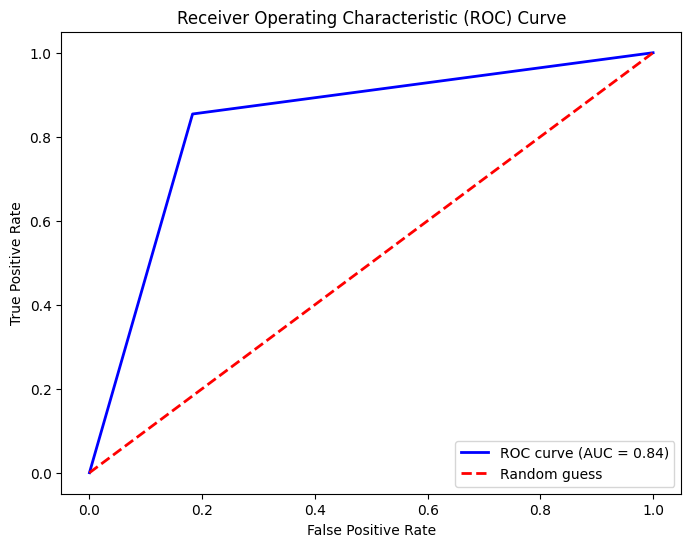

In [76]:
# Compute ROC curve and AUC and store the AUC value
NN_roc =roc_func(np.array(y_true), np.array(y_pred))

The result are in line with what we found with the previous procedures, but we will postpone the comparison to next section.

# Comparison between methods

In this section, we want to compare all the results obtained with various methods and different kind of implementation.

We create a dataframe to store the name of the method, its validation accuracy, its AUC value and its misclassified 'yes'.

In [77]:
# Create an empty DataFrame with 8 rows and 3 columns
df = pd.DataFrame(index=range(7), columns=['Method', 'Accuracy score', 'AUC value', 'Misclassification of yes'])

We store the information saved before.

In [78]:
df.loc[0] = ['Logistics Regression', f'{round(LR_acc*100,2)}%', f'{round(LR_roc*100,2)}%', f'{round(LR_mis*100,2)}%']
df.loc[1] = ['K nearest neighbors', f'{round(KNN_acc*100,2)}%', f'{round(KNN_roc*100,2)}%', f'{round(KNN_mis*100,2)}%']
df.loc[2] = ['Support Vector Machines', f'{round(SVM_acc*100,2)}%', f'{round(SVM_roc*100,2)}%', f'{round(SVM_mis*100,2)}%']
df.loc[3] = ['Logistics Regression resampled', f'{round(R_LR_acc*100,2)}%', f'{round(R_LR_roc*100,2)}%', f'{round(R_LR_mis*100,2)}%']
df.loc[4] = ['K nearest neighbors resampled', f'{round(R_KNN_acc*100,2)}%', f'{round(R_KNN_roc*100,2)}%', f'{round(R_KNN_mis*100,2)}%']
df.loc[5] = ['Support Vector Machines resampled', f'{round(R_SVM_acc*100,2)}%', f'{round(R_SVM_roc*100,2)}%', f'{round(R_SVM_mis*100,2)}%']
df.loc[6] = ['Neural Network resampled', f'{round(NN_acc*100,2)}%', f'{round(NN_roc*100,2)}%', f'{round(NN_mis*100,2)}%']

Now we look at all the results and in the final section we will comment them.

In [79]:
df

,Method,Accuracy score,AUC value,Misclassification of yes
0,Logistics Regression,89.09%,60.28%,77.23%
1,K nearest neighbors,89.62%,63.01%,71.63%
2,Support Vector Machines,89.81%,65.77%,65.52%
3,Logistics Regression resampled,80.56%,80.56%,19.28%
4,K nearest neighbors resampled,85.73%,85.79%,10.99%
5,Support Vector Machines resampled,85.44%,85.51%,11.25%
6,Neural Network resampled,83.52%,83.56%,14.59%


This table displays the accuracy scores, AUC values, and percentages of misclassified 'yes' instances for all implemented methods. As previously noted, while the initial three methods exhibit higher accuracy compared to those applied post-resampling, the latter methods demonstrate superior AUC values. Consequently, they show a reduced percentage of misclassified 'yes' instances. This improvement suggests a preference for the latter models, particularly because they effectively address the initial bias toward the 'no' class, enhancing the prediction accuracy for 'yes' instances.
Finally, we decide to select the model with highest AUC value, considered a valuable metric after completing this project. The best model implements the K-Nearest Neighbors method with an accuracy fo 85.73%, an AUC value of 85.79% and with a reasonable percentage of misclassified 'yes' of 10.99%. Overall also the other methods after resampling, except maybe for the Logistic Regression, performed very well. Additionally, by running the code several times, we noticed that sometimes SVM is better than KNN and viceversa, meaning than within the resampling procedure, there are some random factors that may change which method is slightly better.

# Final conclusions

The primary objective of this analysis was to demonstrate that an accuracy score alone does not adequately indicate whether a model is well-trained or capable of generating valuable predictions. In this project, we  individually used the accuracy score recurrently to compare results while implementing cross-validation for each method. However, our analysis clearly illustrated the challenges posed by an unbalanced dataset, particularly reflected in the high percentage of misclassified 'yes' instances due to the overwhelming number of 'no' responses. We found that employing a resampled and balanced dataset significantly mitigates these issues. Consequently, even though the accuracy might be marginally lower with a balanced dataset, the predictions are notably less biased, making them more reliable and valuable in practical scenarios. 
It would be beneficial to expand the dataset with additional observations and utilize these to make predictions using our most recent models. Although implementing a random forest could have offered another point of comparison, the four methods and seven models already compared sufficiently demonstrate that accuracy alone can sometimes be an inadequate measure of a model's predictive capabilities. 

We also gained a deeper understanding of the crucial role that data resampling plays in our analyses, an aspect that we hadn't encountered in our previous 'Hands-on' sessions, or at least, it wasn't a focal point at that time. This realization highlights the importance of periodically revisiting and refining our data handling techniques to ensure robustness and accuracy in our results.